# Data analysis M12 StegAdventure Research Project

## Gather data from database

In [1]:
import os
import pymysql
from dotenv import load_dotenv
from collections import defaultdict

load_dotenv()

DB_HOST = os.getenv('DB_HOST')
DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_DATABASE = os.getenv('DB_DATABASE')

try:
    connection = pymysql.connect(
        host=DB_HOST,
        port=3306,
        user=DB_USER,
        password=DB_PASSWORD,
        database=DB_DATABASE,
    )
    print("Connected to the MySQL database!")

    # Get database data
    with connection.cursor() as cursor:
        # Fetch participants
        cursor.execute("SELECT id, in_game_group FROM participants WHERE has_finished = TRUE")
        participants_result = cursor.fetchall()

        # Fetch profiles
        cursor.execute("SELECT * FROM profiles")
        profiles_result = cursor.fetchall()

        # Fetch User Engagement Form
        cursor.execute("SELECT * FROM u_e_s")
        ues_result = cursor.fetchall()

        # Fetch tests
        cursor.execute("SELECT * FROM tests")
        tests_result = cursor.fetchall()

        # Fetch feedback
        cursor.execute("SELECT * FROM feedback")
        feedback_result = cursor.fetchall()

        # Fetch reading time
        cursor.execute("SELECT * FROM readings")
        readings_result = cursor.fetchall()

        # Fetch games
        cursor.execute("SELECT * FROM games")
        games_result = cursor.fetchall()

        # Fetch game time
        cursor.execute("SELECT participant_id, MAX(time_since_start) FROM games GROUP BY participant_id")
        games_time_result = cursor.fetchall()

        # ----- CREATE READABLE DICTIONARY -----
        profiles_dict = {row[0]: {
            "age": row[1],
            "main_expertise": row[2],
            "education": row[3],
            "gaming_experience": row[4],
            "cybersecurity": row[5],
            "steganography": row[6],
            "stego_explanation": row[7]
        } for row in profiles_result}

        ues_dict = {row[0]:
            {"ues": {
                "fas1": row[1],
                "fas2": row[2],
                "fas3": row[3],
                "pus1": row[4],
                "pus2": row[5],
                "pus3": row[6],
                "aes1": row[7],
                "aes2": row[8],
                "aes3": row[9],
                "rws1": row[10],
                "rws2": row[11],
                "rws3": row[12],
            }
            } for row in ues_result}

        tests_dict = {row[0]:
            {"test": {
                "question1": row[1],
                "question2": row[2],
                "question3": row[3],
                "question4": row[4],
                "question5": row[5],
                "question6": row[6],
                "question7": row[7],
                "question8": row[8],
                "question9": row[9],
                "time_since_start": row[10],
                "score": row[11],
                "question1_points": row[12],
                "question2_points": row[13],
                "question3_points": row[14],
                "question4_points": row[15],
                "question5_points": row[16],
                "question6_points": row[17],
                "question7_points": row[18],
                "question8_points": row[19],
                "question9_points": row[20],
            }
            } for row in tests_result}

        feedback_dict = {row[0]:
            {"feedback": {
                "game_improvements": row[1],
                "text_improvements": row[2],
                "other_improvements": row[3],
            }
            } for row in feedback_result}

        readings_dict = {row[0]:
            {"reading": {
                "time_since_start": row[1],
            }
            } for row in readings_result}

        games_time_dict = {row[0]:
            {"games": {
                "end_time": row[1],
            }
            } for row in games_time_result}

        # Create a dictionary to group data by participant_id
        games_dict = defaultdict(lambda: {"games": {"node": []}})

        # Iterate over games_result and append each row's data to the appropriate participant_id
        for row in games_result:
            participant_id = row[0]
            node_data = {
                "id": row[1],
                "time_since_start": row[2],
                "choice": row[3],
            }
            games_dict[participant_id]["games"]["node"].append(node_data)

        # Convert defaultdict to a regular dictionary
        games_dict = dict(games_dict)

        # Combine games_time_dict and games_dict
        combined_games_dict = defaultdict(lambda: {"games": {"node": [], "end_time": None}})

        # Add nodes from games_dict
        for participant_id, game_data in games_dict.items():
            combined_games_dict[participant_id]["games"]["node"] = game_data["games"]["node"]

        # Add end_time from games_time_dict
        for participant_id, time_data in games_time_dict.items():
            combined_games_dict[participant_id]["games"]["end_time"] = time_data["games"]["end_time"]

        # Convert defaultdict to a regular dictionary
        combined_games_dict = dict(combined_games_dict)

        # ----- MERGE ALL RESULTS -----
        result = {
            participant[0]: {
                "in_game_group": participant[1],
                **profiles_dict[participant[0]],
                **ues_dict[participant[0]],
                **tests_dict[participant[0]],
                **feedback_dict[participant[0]],
                **combined_games_dict.get(participant[0], {}),  # Only add when there is data
                **readings_dict.get(participant[0], {}),  # Only add when there is data
            }
            for participant in participants_result
        }

    # Close connection
    connection.close()
    print("Database connection closed.")

except Exception as e:
    print(f"An error occurred: {e}")

Connected to the MySQL database!
Database connection closed.


## Education level of participants

In [2]:
def grade(score):
    return max(0, score) / 54 * 9 + 1

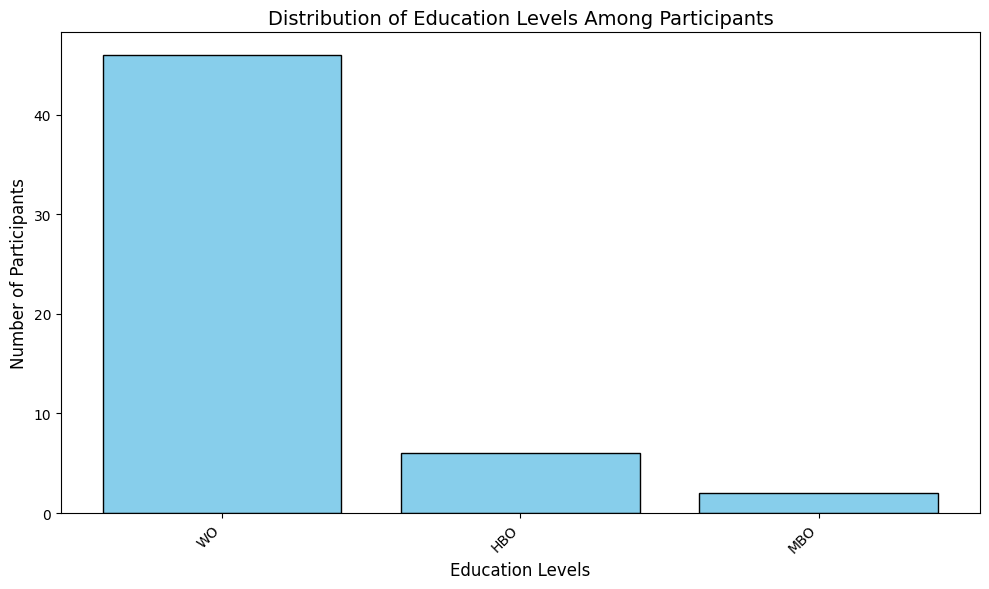

In [3]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract education levels from the result dictionary
education_levels = [participant_data["education"] for participant_data in result.values()]

# Count occurrences of each education level
education_counts = Counter(education_levels)

# Prepare data for the bar chart
education_labels = list(education_counts.keys())
education_values = list(education_counts.values())

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(education_labels, education_values, color='skyblue', edgecolor='black')
plt.xlabel("Education Levels", fontsize=12)
plt.ylabel("Number of Participants", fontsize=12)
plt.title("Distribution of Education Levels Among Participants", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()


## Distribution of education level per group

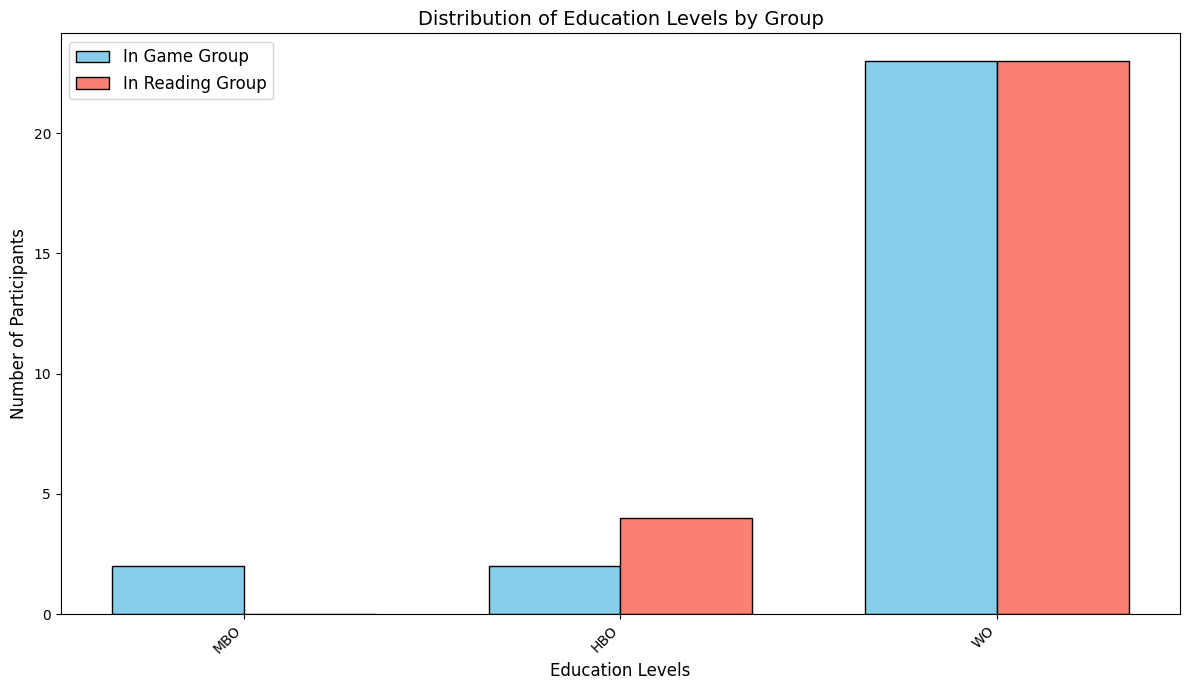

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Separate participants based on in_game_group
in_game_group = [participant_data["education"] for participant_data in result.values() if
                 participant_data["in_game_group"]]
not_in_game_group = [participant_data["education"] for participant_data in result.values() if
                     not participant_data["in_game_group"]]

# Count occurrences of each education level for both groups
in_game_counts = Counter(in_game_group)
not_in_game_counts = Counter(not_in_game_group)

# Get all unique education levels
all_education_levels = list(set(in_game_counts.keys()).union(set(not_in_game_counts.keys())))

# Ensure all levels are represented in both counts
in_game_values = [in_game_counts.get(level, 0) for level in all_education_levels]
not_in_game_values = [not_in_game_counts.get(level, 0) for level in all_education_levels]

# Plot the grouped bar chart
x = np.arange(len(all_education_levels))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(12, 7))
plt.bar(x - width / 2, in_game_values, width, label='In Game Group', color='skyblue', edgecolor='black')
plt.bar(x + width / 2, not_in_game_values, width, label='In Reading Group', color='salmon', edgecolor='black')

# Add labels, title, and legend
plt.xlabel("Education Levels", fontsize=12)
plt.ylabel("Number of Participants", fontsize=12)
plt.title("Distribution of Education Levels by Group", fontsize=14)
plt.xticks(x, all_education_levels, rotation=45, ha='right', fontsize=10)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [5]:
from scipy.stats import mannwhitneyu

# Map education levels to numeric values
education_map = {'MBO': 1, 'HBO': 2, 'WO': 3}
in_game_numeric = [education_map[edu] for edu in in_game_group]
not_in_game_numeric = [education_map[edu] for edu in not_in_game_group]

print("Null hypothesis: there is no difference in education")
# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(in_game_numeric, not_in_game_numeric, alternative='two-sided')

# Print the results
print(f"U statistic: {stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant difference in education levels between the two groups.")
else:
    print("There is no statistically significant difference in education levels between the two groups.")

print("Null hypothesis: the game group has a lower education")
# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(in_game_numeric, not_in_game_numeric, alternative='less')

# Print the results
print(f"U statistic: {stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant difference in education levels between the two groups.")
else:
    print("There is no statistically significant difference in education levels between the two groups.")


Null hypothesis: there is no difference in education
U statistic: 360.5
P-value: 0.921811120674122
There is no statistically significant difference in education levels between the two groups.
Null hypothesis: the game group has a lower education
U statistic: 360.5
P-value: 0.460905560337061
There is no statistically significant difference in education levels between the two groups.


## Age distribution

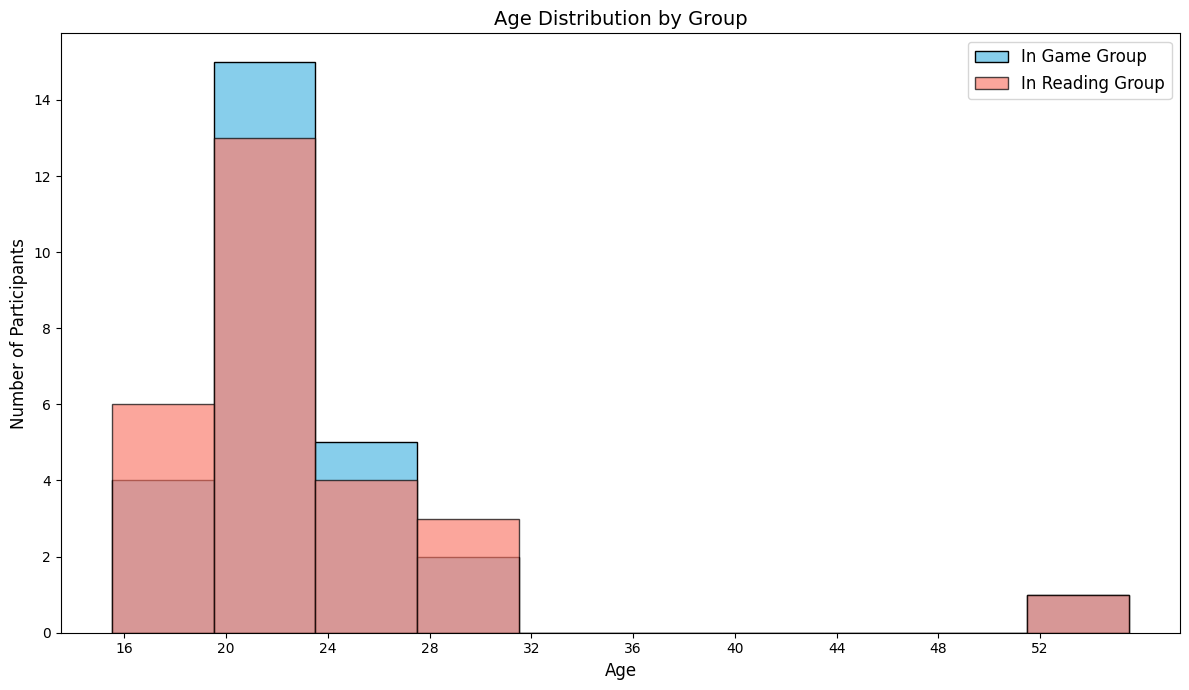

In [6]:
import matplotlib.pyplot as plt

# Separate ages based on in_game_group
ages_in_game_group = [participant_data["age"] for participant_data in result.values() if
                      participant_data["in_game_group"]]
ages_not_in_game_group = [participant_data["age"] for participant_data in result.values() if
                          not participant_data["in_game_group"]]

# Define the number of bins for the histogram
bins = np.arange(min(ages_in_game_group + ages_not_in_game_group),
                 max(ages_in_game_group + ages_not_in_game_group) + 2,
                 step=4) - 0.5

# Plot histograms
plt.figure(figsize=(12, 7))
plt.hist(ages_in_game_group, bins=bins, alpha=1, label='In Game Group', color='skyblue', edgecolor='black')
plt.hist(ages_not_in_game_group, bins=bins, alpha=0.7, label='In Reading Group', color='salmon', edgecolor='black')

# Add labels, title, and legend
plt.xlabel("Age", fontsize=12)
plt.ylabel("Number of Participants", fontsize=12)
plt.title("Age Distribution by Group", fontsize=14)

# Adjust x-axis ticks to align with bin edges
plt.xticks(bins[:-1] + 0.5, bins[:-1].astype(int), fontsize=10)  # Center the ticks between bins
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [7]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# Perform Shapiro-Wilk test for normality
shapiro_in_game = shapiro(ages_in_game_group)
shapiro_not_in_game = shapiro(ages_not_in_game_group)

print("Shapiro-Wilk Test Results:")
print(f"In Game Group: W={shapiro_in_game.statistic}, p={shapiro_in_game.pvalue}")
print(f"Not In Game Group: W={shapiro_not_in_game.statistic}, p={shapiro_not_in_game.pvalue}")

# Check if both groups are normally distributed
if shapiro_in_game.pvalue >= 0.05 and shapiro_not_in_game.pvalue >= 0.05:
    print("\nBoth groups are normally distributed. Performing a t-test...")
    # Perform t-test
    t_stat, t_p_value = ttest_ind(ages_in_game_group, ages_not_in_game_group, equal_var=False)
    print(f"T-test Results: t={t_stat}, p={t_p_value}")

    if t_p_value < 0.05:
        print("There is a statistically significant difference in ages between the two groups.")
    else:
        print("There is no statistically significant difference in ages between the two groups.")
else:
    print("\nAt least one group is not normally distributed. Performing a Mann-Whitney U test...")
    # Perform Mann-Whitney U test
    u_stat, u_p_value = mannwhitneyu(ages_in_game_group, ages_not_in_game_group, alternative='two-sided')
    print(f"Mann-Whitney U Test Results: U={u_stat}, p={u_p_value}")

    if u_p_value < 0.05:
        print("There is a statistically significant difference in ages between the two groups.")
    else:
        print("There is no statistically significant difference in ages between the two groups.")


Shapiro-Wilk Test Results:
In Game Group: W=0.6000043205115269, p=2.065905123503975e-07
Not In Game Group: W=0.6054667690390925, p=2.3950260398454654e-07

At least one group is not normally distributed. Performing a Mann-Whitney U test...
Mann-Whitney U Test Results: U=391.5, p=0.6436618469176394
There is no statistically significant difference in ages between the two groups.


## Main expertise distribution

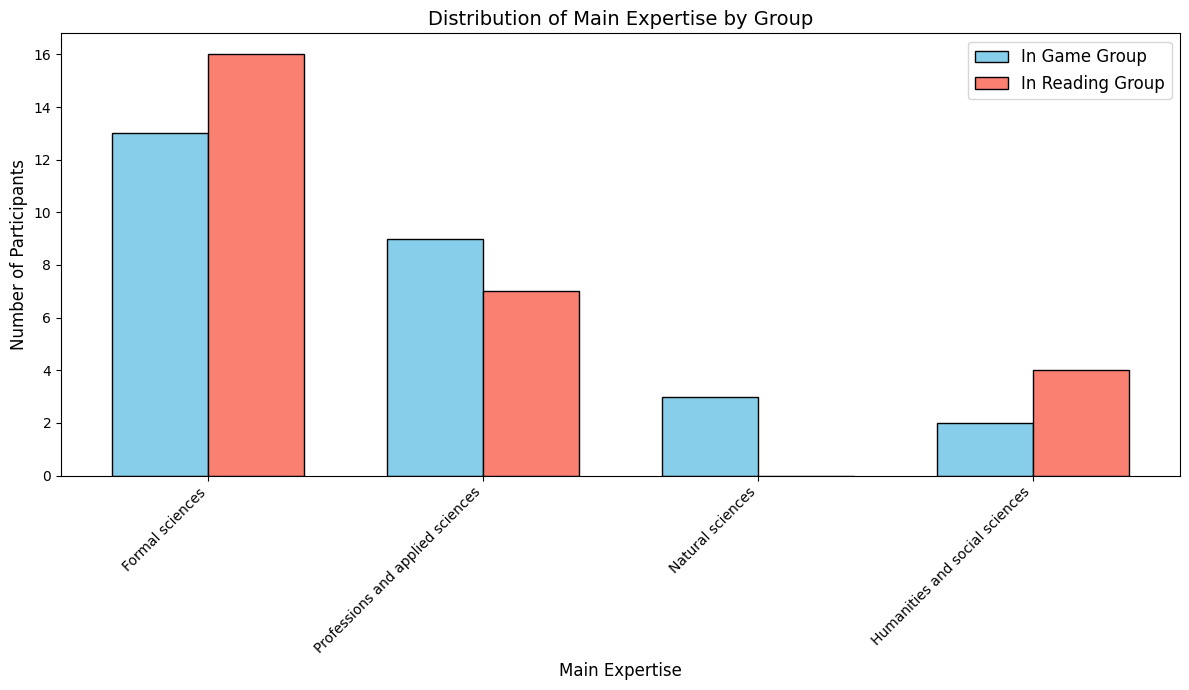

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

# Separate main expertise based on in_game_group
expertise_in_game_group = [participant_data["main_expertise"] for participant_data in result.values() if
                           participant_data["in_game_group"]]
expertise_not_in_game_group = [participant_data["main_expertise"] for participant_data in result.values() if
                               not participant_data["in_game_group"]]

# Count occurrences of each main expertise for both groups
in_game_counts = Counter(expertise_in_game_group)
not_in_game_counts = Counter(expertise_not_in_game_group)

# Get all unique expertise categories
all_expertise_categories = list(set(in_game_counts.keys()).union(set(not_in_game_counts.keys())))

# Ensure all categories are represented in both counts
in_game_values = [in_game_counts.get(category, 0) for category in all_expertise_categories]
not_in_game_values = [not_in_game_counts.get(category, 0) for category in all_expertise_categories]

# Plot the grouped bar chart
x = np.arange(len(all_expertise_categories))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(12, 7))
plt.bar(x - width / 2, in_game_values, width, label='In Game Group', color='skyblue', edgecolor='black')
plt.bar(x + width / 2, not_in_game_values, width, label='In Reading Group', color='salmon', edgecolor='black')

# Add labels, title, and legend
plt.xlabel("Main Expertise", fontsize=12)
plt.ylabel("Number of Participants", fontsize=12)
plt.title("Distribution of Main Expertise by Group", fontsize=14)
plt.xticks(x, all_expertise_categories, rotation=45, ha='right', fontsize=10)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [9]:
import numpy as np
from scipy.stats import chi2_contingency

# Create the contingency table
contingency_table = np.array([in_game_values, not_in_game_values])

# Perform the chi-square test for independence
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-Square Statistic:", chi2_stat)
print("P-Value:", p_value)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:")
print(expected)

# Check the minimum expected frequency
min_expected = np.min(expected)
print("Minimum Expected Frequency:", min_expected)

if min_expected < 5:
    print("\nWarning: Some expected frequencies are less than 5. The chi-square test may not be valid.")
else:
    print("\nAll expected frequencies are at least 5. The chi-square test is valid.")

# Draw a conclusion based on the p-value
alpha = 0.05  # Common significance level
if p_value < alpha:
    print("\nConclusion: There is a statistically significant difference in the distribution of main expertise between the two groups (p < 0.05)")
else:
    print("\nConclusion: There is no statistically significant difference in the distribution of main expertise between the two groups (p >= 0.05), so there is no association between the two variables (e.g., group membership and expertise categories). In other words, the variables are independent.")


Chi-Square Statistic: 4.227011494252873
P-Value: 0.23797139837573134
Degrees of Freedom: 3
Expected Frequencies:
[[14.5  8.   1.5  3. ]
 [14.5  8.   1.5  3. ]]
Minimum Expected Frequency: 1.5


Conclusion: There is no statistically significant difference in the distribution of main expertise between the two groups (p >= 0.05), so there is no association between the two variables (e.g., group membership and expertise categories). In other words, the variables are independent.


## Gaming experience distribution

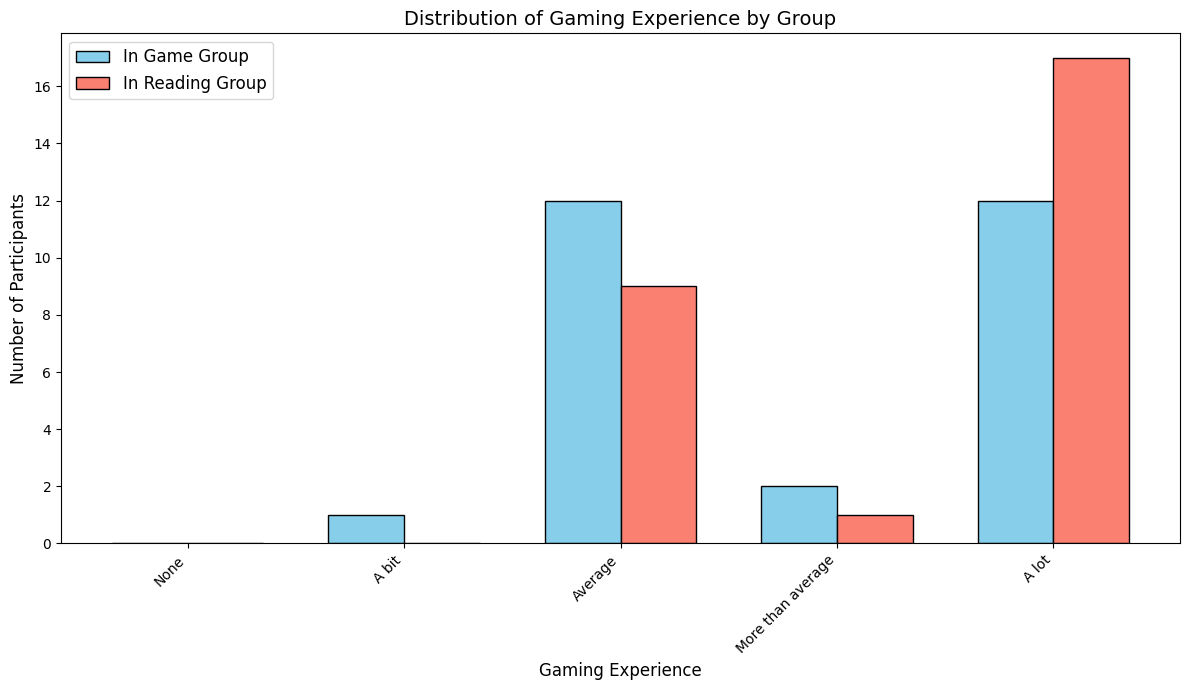

In [10]:
import matplotlib.pyplot as plt
from collections import Counter

# Separate gaming experience based on in_game_group
gaming_experience_in_game_group = [participant_data["gaming_experience"] for participant_data in result.values() if
                                   participant_data["in_game_group"]]
gaming_experience_in_reading_group = [participant_data["gaming_experience"] for participant_data in result.values() if
                                      not participant_data["in_game_group"]]

# Define the desired order of labels
experience_levels_order = ['None', 'A bit', 'Average', 'More than average', 'A lot']

# Count occurrences of each gaming experience level for both groups
in_game_counts = Counter(gaming_experience_in_game_group)
in_reading_counts = Counter(gaming_experience_in_reading_group)

# Ensure all levels are represented in both counts in the specified order
in_game_values = [in_game_counts.get(level, 0) for level in experience_levels_order]
in_reading_values = [in_reading_counts.get(level, 0) for level in experience_levels_order]

# Plot the grouped bar chart
x = np.arange(len(experience_levels_order))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(12, 7))
plt.bar(x - width / 2, in_game_values, width, label='In Game Group', color='skyblue', edgecolor='black')
plt.bar(x + width / 2, in_reading_values, width, label='In Reading Group', color='salmon', edgecolor='black')

# Add labels, title, and legend
plt.xlabel("Gaming Experience", fontsize=12)
plt.ylabel("Number of Participants", fontsize=12)
plt.title("Distribution of Gaming Experience by Group", fontsize=14)
plt.xticks(x, experience_levels_order, rotation=45, ha='right', fontsize=10)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [11]:
# Map gaming experience levels to numeric values
experience_map = {'None': 1, 'A bit': 2, 'Average': 3, 'More than average': 4, 'A lot': 5}
in_game_numeric = [experience_map[exp] for exp in gaming_experience_in_game_group]
in_reading_numeric = [experience_map[exp] for exp in gaming_experience_in_reading_group]

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(in_game_numeric, in_reading_numeric, alternative='two-sided')

# Print the results
print(f"U statistic: {stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant difference in gaming experience between the two groups.")
else:
    print("There is no statistically significant difference in gaming experience between the two groups.")


U statistic: 295.0
P-value: 0.17827259207409418
There is no statistically significant difference in gaming experience between the two groups.


## Steganography knowledge distribution

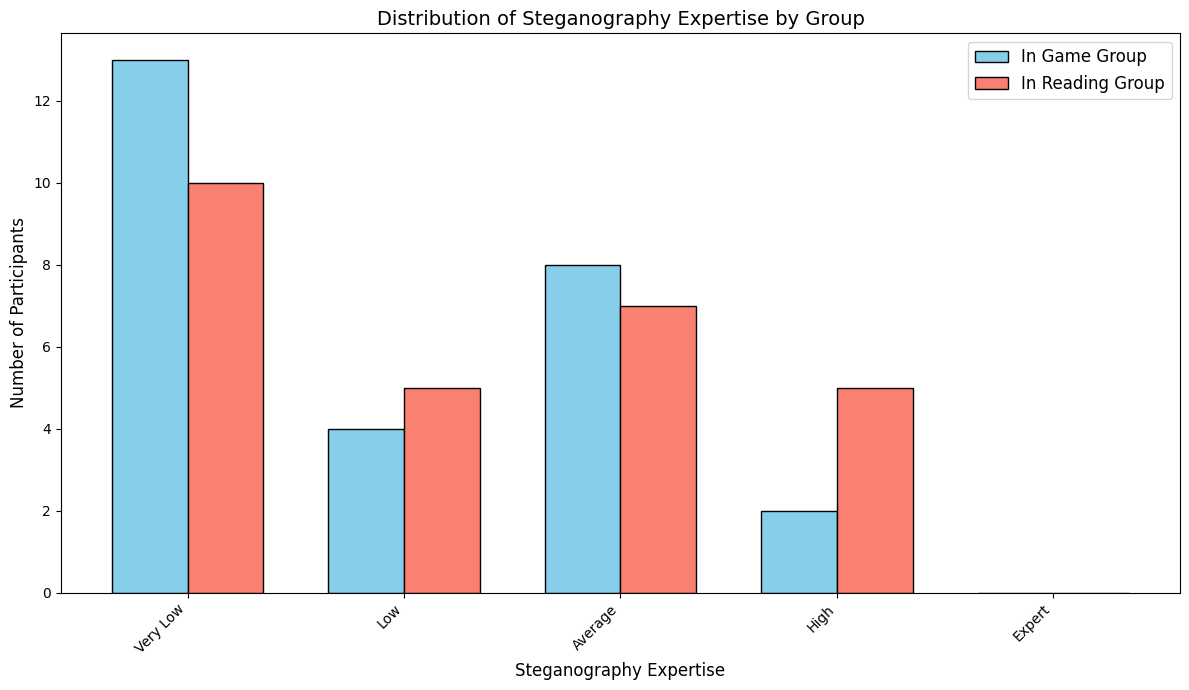

In [12]:
import matplotlib.pyplot as plt
from collections import Counter

# Separate steganography levels based on in_game_group
steganography_in_game_group = [participant_data["steganography"] for participant_data in result.values() if
                               participant_data["in_game_group"]]
steganography_in_reading_group = [participant_data["steganography"] for participant_data in result.values() if
                                  not participant_data["in_game_group"]]

# Define the desired order of labels
steganography_levels_order = ['Very Low', 'Low', 'Average', 'High', 'Expert']

# Count occurrences of each steganography level for both groups
in_game_counts = Counter(steganography_in_game_group)
in_reading_counts = Counter(steganography_in_reading_group)

# Ensure all levels are represented in both counts in the specified order
in_game_values = [in_game_counts.get(level, 0) for level in steganography_levels_order]
in_reading_values = [in_reading_counts.get(level, 0) for level in steganography_levels_order]

# Plot the grouped bar chart
x = np.arange(len(steganography_levels_order))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(12, 7))
plt.bar(x - width / 2, in_game_values, width, label='In Game Group', color='skyblue', edgecolor='black')
plt.bar(x + width / 2, in_reading_values, width, label='In Reading Group', color='salmon', edgecolor='black')

# Add labels, title, and legend
plt.xlabel("Steganography Expertise", fontsize=12)
plt.ylabel("Number of Participants", fontsize=12)
plt.title("Distribution of Steganography Expertise by Group", fontsize=14)
plt.xticks(x, steganography_levels_order, rotation=45, ha='right', fontsize=10)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [13]:
from scipy.stats import mannwhitneyu

# Map steganography levels to numeric values
steganography_map = {'Very Low': 1, 'Low': 2, 'Average': 3, 'High': 4, 'Expert': 5}
in_game_numeric = [steganography_map[exp] for exp in steganography_in_game_group]
in_reading_numeric = [steganography_map[exp] for exp in steganography_in_reading_group]

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(in_game_numeric, in_reading_numeric, alternative='two-sided')

# Print the results
print(f"U statistic: {stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant difference in steganography expertise between the two groups.")
else:
    print("There is no statistically significant difference in steganography expertise between the two groups.")


U statistic: 312.0
P-value: 0.341597623330845
There is no statistically significant difference in steganography expertise between the two groups.


## Cybersecurity knowledge distribution

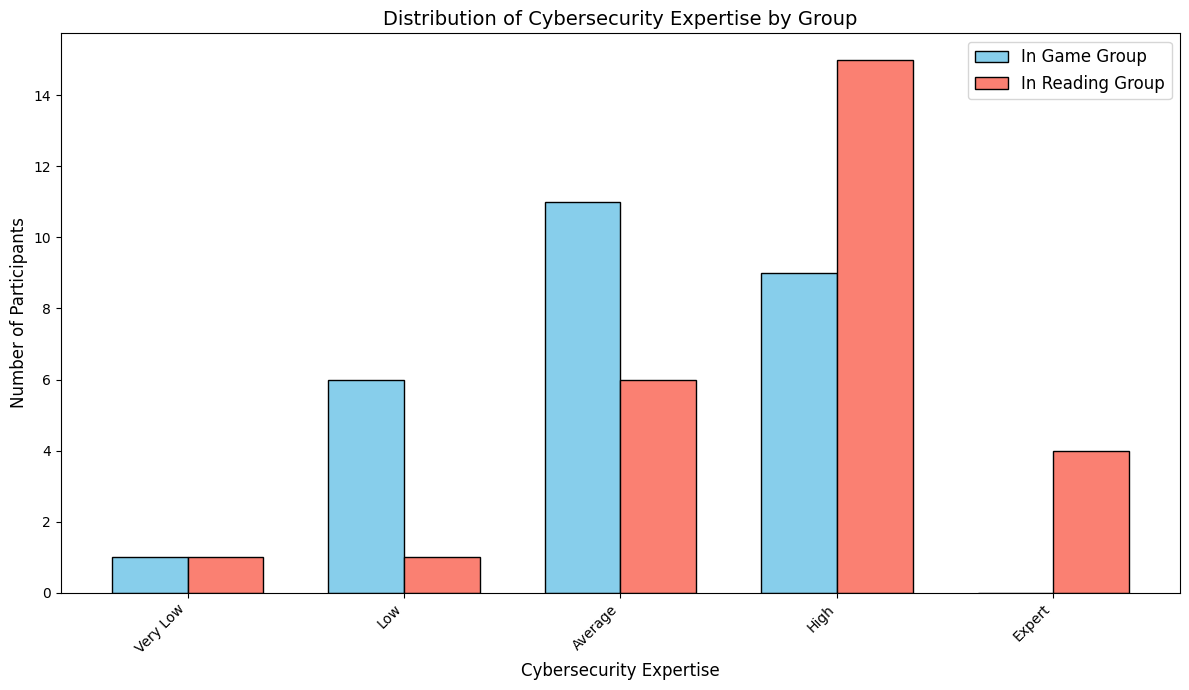

In [14]:
import matplotlib.pyplot as plt
from collections import Counter

# Separate cybersecurity levels based on in_game_group
cybersecurity_in_game_group = [participant_data["cybersecurity"] for participant_data in result.values() if
                               participant_data["in_game_group"]]
cybersecurity_in_reading_group = [participant_data["cybersecurity"] for participant_data in result.values() if
                                  not participant_data["in_game_group"]]

# Define the desired order of labels
cybersecurity_levels_order = ['Very Low', 'Low', 'Average', 'High', 'Expert']

# Count occurrences of each cybersecurity level for both groups
in_game_counts = Counter(cybersecurity_in_game_group)
in_reading_counts = Counter(cybersecurity_in_reading_group)

# Ensure all levels are represented in both counts in the specified order
in_game_values = [in_game_counts.get(level, 0) for level in cybersecurity_levels_order]
in_reading_values = [in_reading_counts.get(level, 0) for level in cybersecurity_levels_order]

# Plot the grouped bar chart
x = np.arange(len(cybersecurity_levels_order))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(12, 7))
plt.bar(x - width / 2, in_game_values, width, label='In Game Group', color='skyblue', edgecolor='black')
plt.bar(x + width / 2, in_reading_values, width, label='In Reading Group', color='salmon', edgecolor='black')

# Add labels, title, and legend
plt.xlabel("Cybersecurity Expertise", fontsize=12)
plt.ylabel("Number of Participants", fontsize=12)
plt.title("Distribution of Cybersecurity Expertise by Group", fontsize=14)
plt.xticks(x, cybersecurity_levels_order, rotation=45, ha='right', fontsize=10)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [15]:
from scipy.stats import mannwhitneyu

# Map cybersecurity levels to numeric values
cybersecurity_map = {'Very Low': 1, 'Low': 2, 'Average': 3, 'High': 4, 'Expert': 5}
in_game_numeric = [cybersecurity_map[level] for level in cybersecurity_in_game_group]
in_reading_numeric = [cybersecurity_map[level] for level in cybersecurity_in_reading_group]

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(in_game_numeric, in_reading_numeric, alternative='two-sided')

# Print the results
print(f"U statistic: {stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant difference in cybersecurity expertise between the two groups.")
else:
    print("There is no statistically significant difference in cybersecurity expertise between the two groups.")


U statistic: 204.0
P-value: 0.003147832224788636
There is a statistically significant difference in cybersecurity expertise between the two groups.


## Stego explanation distribution

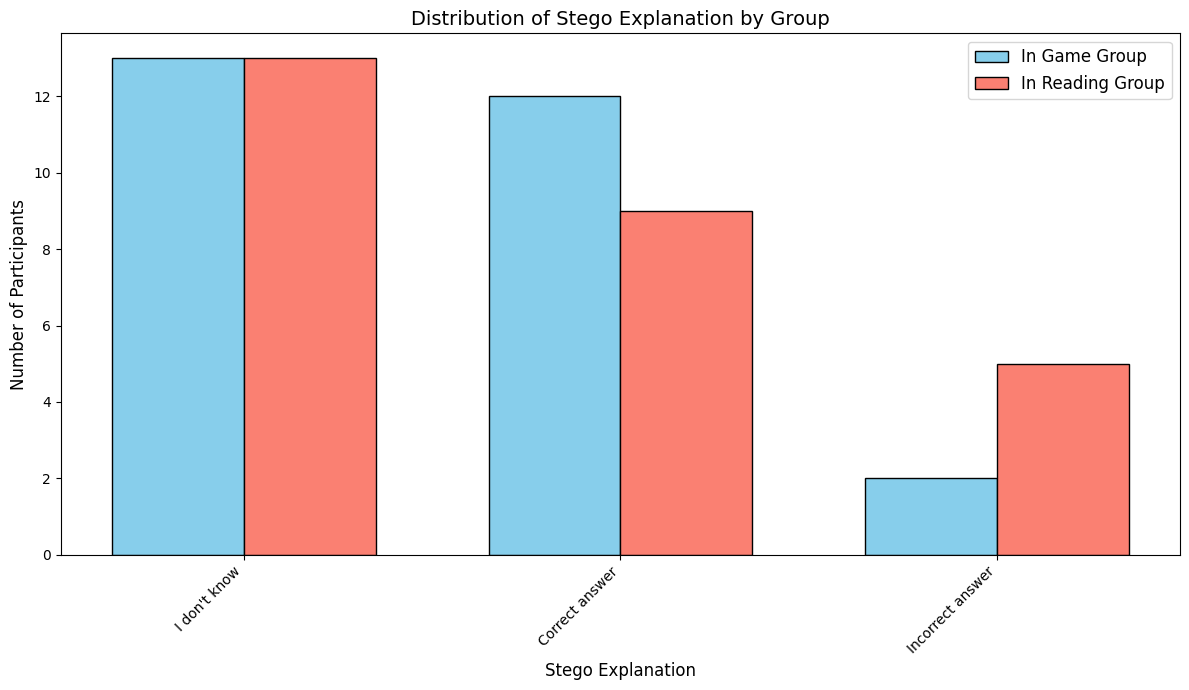

In [16]:
import matplotlib.pyplot as plt
from collections import Counter

# Separate stego_explanation values based on in_game_group
stego_explanation_in_game_group = [participant_data["stego_explanation"] for participant_data in result.values() if
                                   participant_data["in_game_group"]]
stego_explanation_in_reading_group = [participant_data["stego_explanation"] for participant_data in result.values() if
                                      not participant_data["in_game_group"]]


# Define the mapping of values to labels
def map_stego_explanation(value):
    if value == "1":
        return "I don't know"
    elif value == "3":
        return "Correct answer"
    else:
        return "Incorrect answer"


# Apply the mapping to the data
mapped_in_game_group = [map_stego_explanation(value) for value in stego_explanation_in_game_group]
mapped_in_reading_group = [map_stego_explanation(value) for value in stego_explanation_in_reading_group]

# Count occurrences of each mapped explanation for both groups
in_game_counts = Counter(mapped_in_game_group)
in_reading_counts = Counter(mapped_in_reading_group)

# Define the order of the labels
stego_explanation_labels = ["I don't know", "Correct answer", "Incorrect answer"]

# Ensure all levels are represented in both counts in the specified order
in_game_values = [in_game_counts.get(label, 0) for label in stego_explanation_labels]
in_reading_values = [in_reading_counts.get(label, 0) for label in stego_explanation_labels]

# Plot the grouped bar chart
x = np.arange(len(stego_explanation_labels))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(12, 7))
plt.bar(x - width / 2, in_game_values, width, label='In Game Group', color='skyblue', edgecolor='black')
plt.bar(x + width / 2, in_reading_values, width, label='In Reading Group', color='salmon', edgecolor='black')

# Add labels, title, and legend
plt.xlabel("Stego Explanation", fontsize=12)
plt.ylabel("Number of Participants", fontsize=12)
plt.title("Distribution of Stego Explanation by Group", fontsize=14)
plt.xticks(x, stego_explanation_labels, rotation=45, ha='right', fontsize=10)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


## Stego knowledge and stego explanation

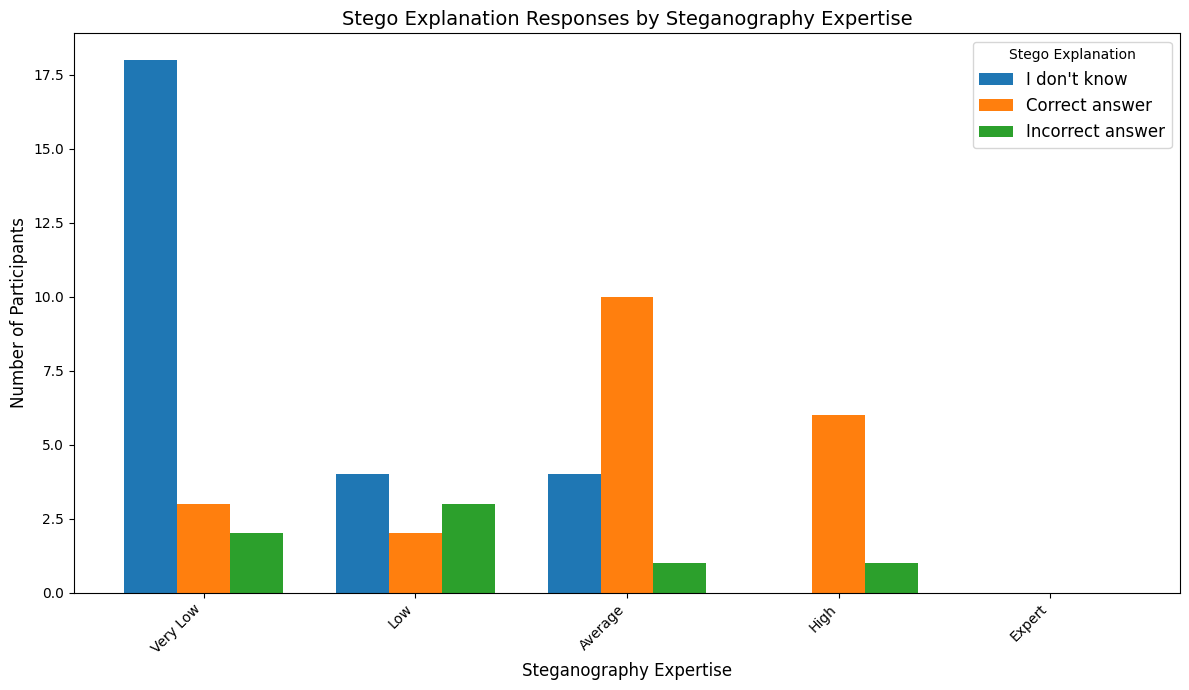

In [17]:
import matplotlib.pyplot as plt
import numpy as np


# Define the mapping of values to labels for stego_explanation
def map_stego_explanation(value):
    if value == "1":
        return "I don't know"
    elif value == "3":
        return "Correct answer"
    else:
        return "Incorrect answer"


# Define the desired order of labels for steganography
steganography_levels_order = ['Very Low', 'Low', 'Average', 'High', 'Expert']
stego_explanation_labels = ["I don't know", "Correct answer", "Incorrect answer"]

# Create dictionaries to hold the counts of stego explanation responses for each steganography level
stego_explanation_by_steganography = {level: {label: 0 for label in stego_explanation_labels} for level in
                                      steganography_levels_order}

# Iterate through all participants and populate the counts
for participant_data in result.values():
    steganography_level = participant_data["steganography"]
    stego_explanation_value = participant_data["stego_explanation"]

    # Map the stego explanation value to the appropriate label
    stego_explanation_label = map_stego_explanation(stego_explanation_value)

    # Update the count for the corresponding steganography level and stego explanation response
    if steganography_level in stego_explanation_by_steganography:
        stego_explanation_by_steganography[steganography_level][stego_explanation_label] += 1

# Now plot the results as a grouped bar chart
fig, ax = plt.subplots(figsize=(12, 7))

# Set the x positions for the steganography levels
x = np.arange(len(steganography_levels_order))  # the label locations
width = 0.25  # the width of the bars

# Prepare the data for plotting
in_game_values = []
in_reading_values = []

# Collect the values for each steganography level and each stego explanation response
for level in steganography_levels_order:
    in_game_values.append(
        [stego_explanation_by_steganography[level].get(label, 0) for label in stego_explanation_labels])

# Convert to a numpy array for easier manipulation
in_game_values = np.array(in_game_values)

# Plot the grouped bar chart
for i, label in enumerate(stego_explanation_labels):
    ax.bar(x + (i - 1) * width, in_game_values[:, i], width, label=label)

# Add labels, title, and legend
ax.set_xlabel("Steganography Expertise", fontsize=12)
ax.set_ylabel("Number of Participants", fontsize=12)
ax.set_title("Stego Explanation Responses by Steganography Expertise", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(steganography_levels_order, rotation=45, ha='right', fontsize=10)
ax.legend(title="Stego Explanation", fontsize=12)

plt.tight_layout()
plt.show()


## Time since start reading group

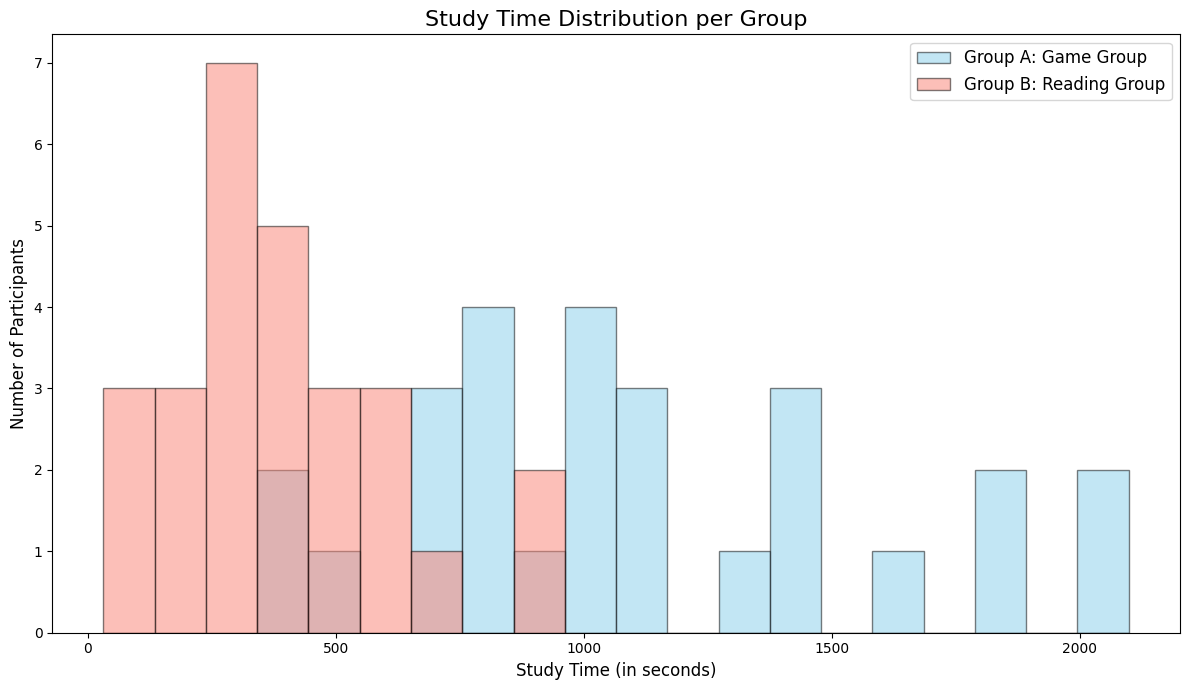

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Extract time_since_start values for the game group from games_time_dict
time_since_start_game_group = [participant_data["games"]["end_time"] for participant_data in result.values() if
                               participant_data["in_game_group"]]

# Extract time_since_start values for the reading group from readings_dict
time_since_start_reading_group = [participant_data["reading"]["time_since_start"] for participant_data in
                                  result.values() if not participant_data["in_game_group"]]

# Combine both lists to determine the global min and max for bins
all_times = time_since_start_reading_group + time_since_start_game_group
min_time = min(all_times)
max_time = max(all_times)

# Define the number of bins (you can adjust this if needed)
bins = np.linspace(min_time, max_time, 21)  # 20 bins (adjust if necessary)

# Plot the histograms for both groups
plt.figure(figsize=(12, 7))

# Plot the game group histogram
plt.hist(time_since_start_game_group, bins=bins, alpha=0.5, label='Group A: Game Group', color='skyblue', edgecolor='black')

# Plot the reading group histogram
plt.hist(time_since_start_reading_group, bins=bins, alpha=0.5, label='Group B: Reading Group', color='salmon', edgecolor='black')

# Add labels and title
plt.xlabel("Study Time (in seconds)", fontsize=12)
plt.ylabel("Number of Participants", fontsize=12)
plt.title("Study Time Distribution per Group", fontsize=16)

# Add a legend to differentiate the groups
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.savefig("graphs/study_time_by_group_histogram.svg", format="svg")
plt.show()


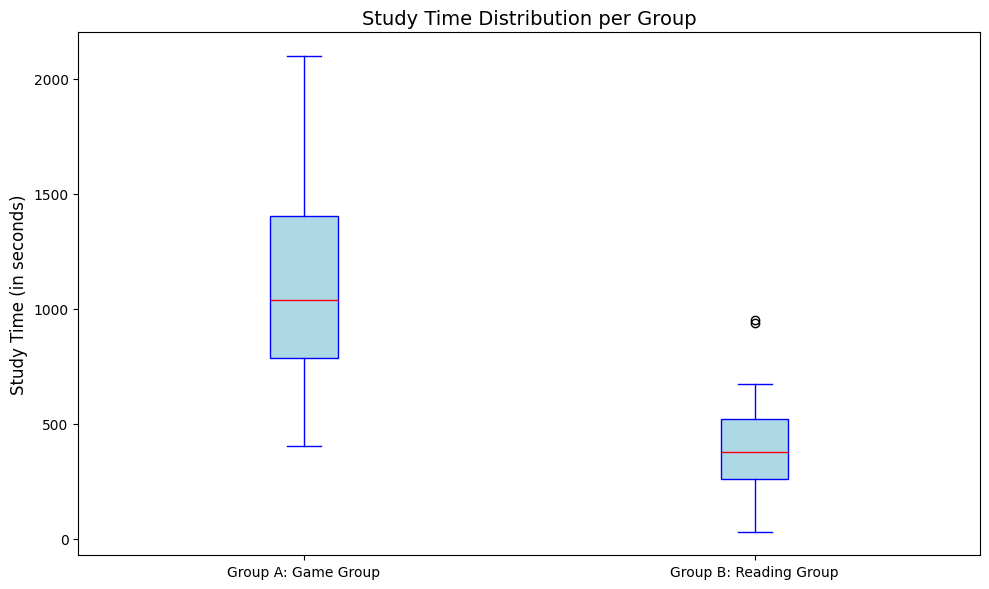

In [19]:
import matplotlib.pyplot as plt

# Data for the two groups
data = [
    time_since_start_game_group,  # Group A: Game Group
    time_since_start_reading_group  # Group B: Reading Group
]

# Labels for the groups
labels = ['Group A: Game Group', 'Group B: Reading Group']

# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(data, tick_labels=labels, patch_artist=True,
            boxprops=dict(facecolor="lightblue", color="blue"),
            medianprops=dict(color="red"),
            whiskerprops=dict(color="blue"),
            capprops=dict(color="blue"))

# Add labels and title
plt.ylabel("Study Time (in seconds)", fontsize=12)
plt.title("Study Time Distribution per Group", fontsize=14)

# Show the plot
plt.tight_layout()
plt.savefig("graphs/study_time_by_group_boxplot.svg", format="svg")
plt.show()


In [20]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from statsmodels.stats.power import TTestIndPower
# Statistical analysis
# Shapiro-Wilk test for normality
shapiro_game = shapiro(time_since_start_game_group)
shapiro_reading = shapiro(time_since_start_reading_group)

print("Shapiro-Wilk Test Results:")
print(f"Game Group: W={shapiro_game.statistic:.4f}, p={shapiro_game.pvalue:.4f}")
print(f"Reading Group: W={shapiro_reading.statistic:.4f}, p={shapiro_reading.pvalue:.4f}")

# Determine if data is normally distributed
if shapiro_game.pvalue > 0.05 and shapiro_reading.pvalue > 0.05:
    print("Both groups appear to be normally distributed. Performing t-test.")
    t_test_result = ttest_ind(time_since_start_game_group, time_since_start_reading_group)
    print(f"T-Test: t={t_test_result.statistic:.4f}, p={t_test_result.pvalue}")
    if t_test_result.pvalue < 0.05:
        print("Conclusion: There is a significant difference between the two groups.")
    else:
        print("Conclusion: There is no significant difference between the two groups.")
    # Calculate Cohen's d
    mean_diff = np.mean(time_since_start_game_group) - np.mean(time_since_start_reading_group)
    pooled_std = np.sqrt(((np.std(time_since_start_game_group, ddof=1) ** 2) + (np.std(time_since_start_reading_group, ddof=1) ** 2)) / 2)
    cohens_d = mean_diff / pooled_std
    print(f"Cohen's d: {cohens_d}")

    # Power analysis
    analysis = TTestIndPower()
    effect_size = cohens_d
    n1 = len(time_since_start_game_group)
    n2 = len(time_since_start_reading_group)
    power = analysis.power(effect_size=effect_size, nobs1=n1, ratio=n2/n1, alpha=0.05)
    print(f"Power of the test: {power}")
else:
    print("At least one group is not normally distributed. Performing Mann-Whitney U test.")
    u_test_result = mannwhitneyu(time_since_start_game_group, time_since_start_reading_group, alternative='two-sided')
    print(f"Mann-Whitney U Test: U={u_test_result.statistic:.4f}, p={u_test_result.pvalue:.4f}")
    if u_test_result.pvalue < 0.05:
        print("Conclusion: There is a significant difference between the two groups.")
    else:
        print("Conclusion: There is no significant difference between the two groups.")


Shapiro-Wilk Test Results:
Game Group: W=0.9456, p=0.1676
Reading Group: W=0.9480, p=0.1916
Both groups appear to be normally distributed. Performing t-test.
T-Test: t=7.0524, p=4.08243690092199e-09
Conclusion: There is a significant difference between the two groups.
Cohen's d: 1.919418457013579
Power of the test: 0.9999996437472894


## Game Paths taken

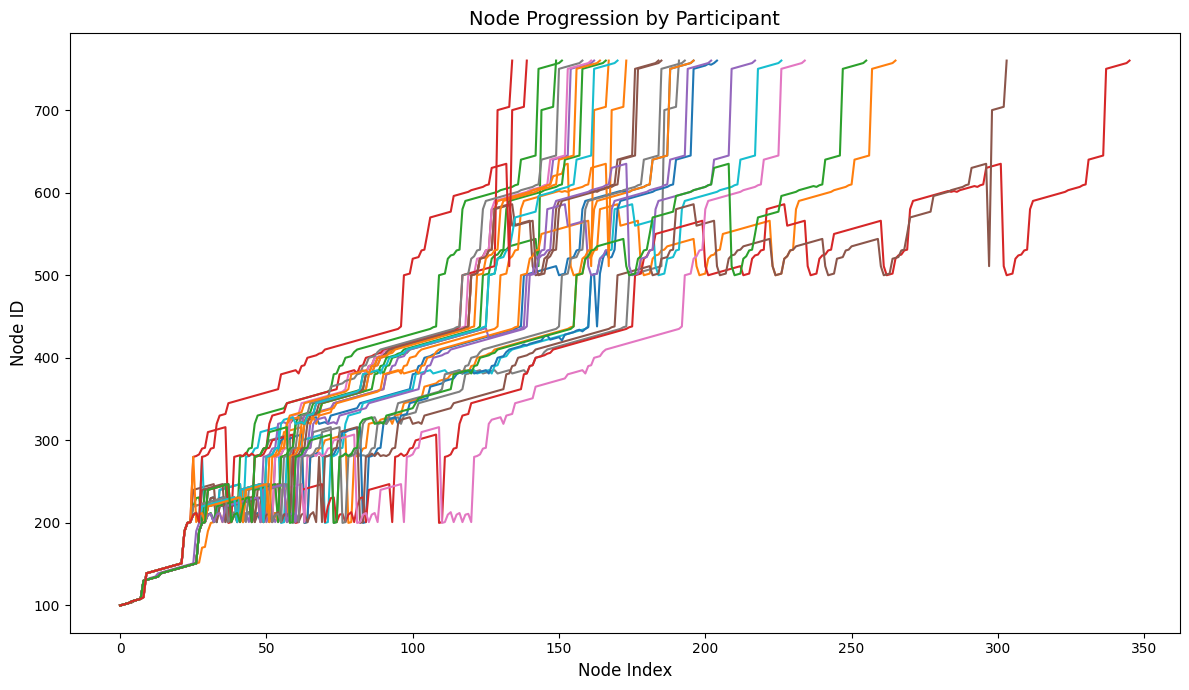

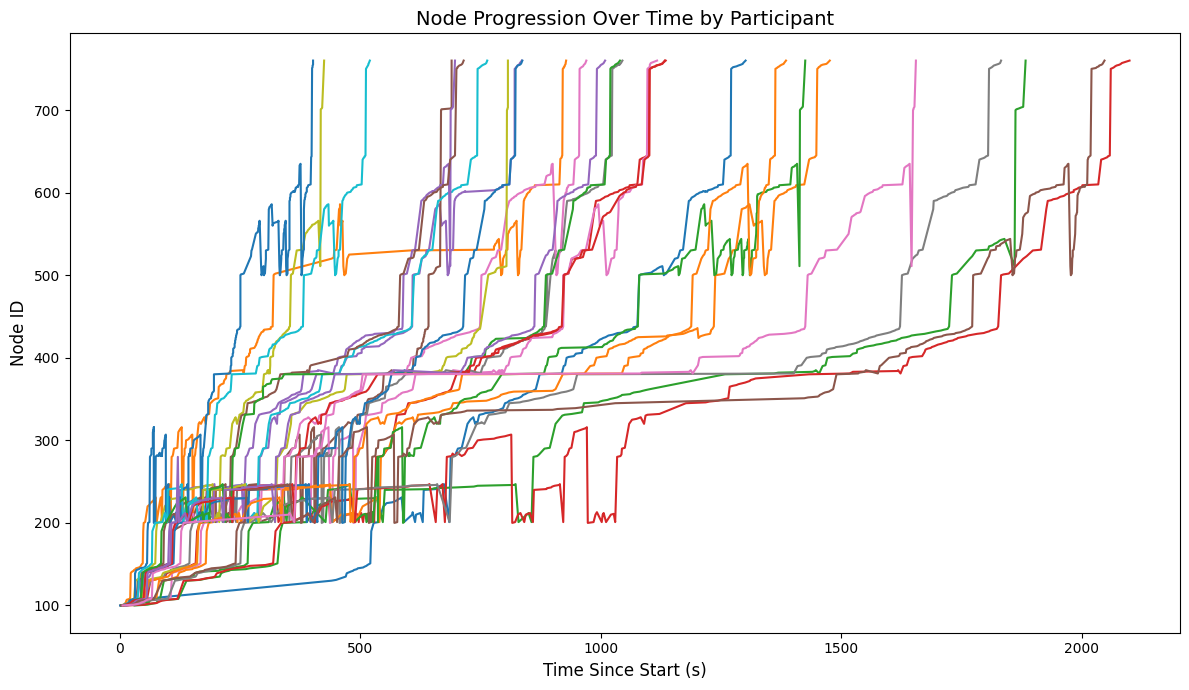

In [21]:
# Prepare data for the line chart
participant_lines = {
    participant_id: [node["id"] for node in data.get("games", {}).get("node", [])]
    for participant_id, data in result.items()
}

# Plot the data
plt.figure(figsize=(12, 7))

for participant_id, nodes in participant_lines.items():
    plt.plot(range(len(nodes)), nodes, label=f'Participant {participant_id}')

# Add labels, title, and legend
plt.xlabel("Node Index", fontsize=12)
plt.ylabel("Node ID", fontsize=12)
plt.title("Node Progression by Participant", fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()

# Prepare data for the line chart
participant_lines = {
    participant_id: {
        "times": [node["time_since_start"] for node in data.get("games", {}).get("node", [])],
        "nodes": [node["id"] for node in data.get("games", {}).get("node", [])]
    }
    for participant_id, data in result.items()
}

# Plot the data
plt.figure(figsize=(12, 7))

for participant_id, data in participant_lines.items():
    if data["times"] and data["nodes"]:  # Ensure there is data to plot
        plt.plot(data["times"], data["nodes"], label=f'Participant {participant_id}')

# Add labels, title, and legend
plt.xlabel("Time Since Start (s)", fontsize=12)
plt.ylabel("Node ID", fontsize=12)
plt.title("Node Progression Over Time by Participant", fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()

# Ending of game

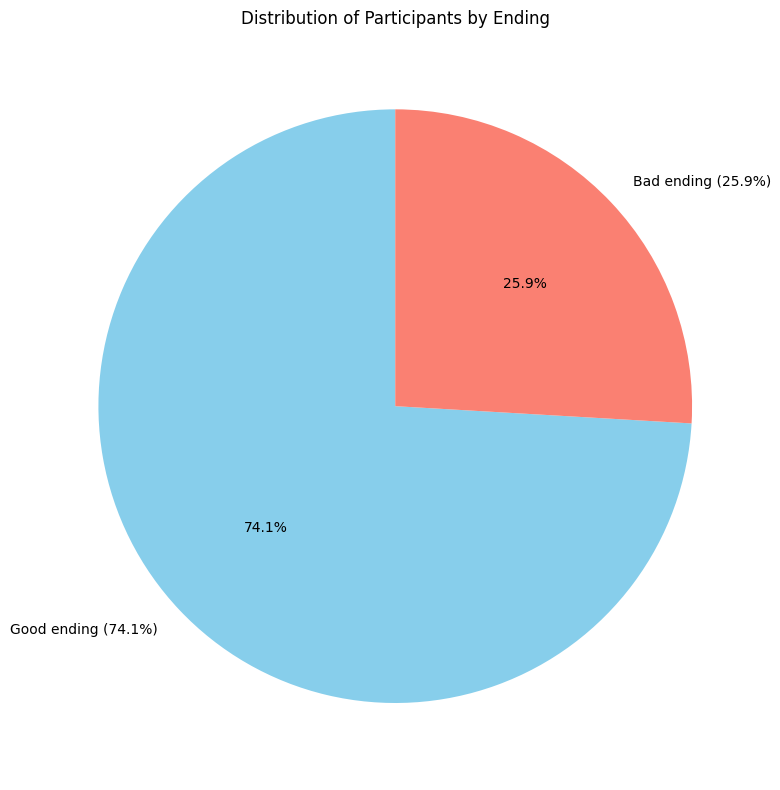

In [22]:
# Count participants for each ending
good_ending_count = sum(
    any(node["id"] == 757 for node in participant.get("games", {}).get("node", []))
    for participant in result.values()
)
bad_ending_count = sum(
    any(node["id"] == 704 for node in participant.get("games", {}).get("node", []))
    for participant in result.values()
)

# Total participants
total_participants = good_ending_count + bad_ending_count

# Labels and sizes for the pie chart
labels = ["Good ending", "Bad ending"]
sizes = [good_ending_count, bad_ending_count]
percentages = [f"{(size / total_participants) * 100:.1f}%" for size in sizes]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=[f"{label} ({percentage})" for label, percentage in zip(labels, percentages)],
    autopct='%1.1f%%',
    startangle=90,
    colors=["skyblue", "salmon"],
)
plt.title("Distribution of Participants by Ending")
plt.axis("equal")  # Equal aspect ratio ensures the pie is drawn as a circle
plt.tight_layout()
plt.show()

## Test scores

Game group
[6.666666666666667, 2.833333333333333, 8.0, 8.666666666666668, 7.0, 3.1666666666666665, 5.5, 5.0, 1.3333333333333333, 8.0, 1.0, 8.166666666666666, 2.6666666666666665, 1.6666666666666665, 4.333333333333333, 8.5, 6.166666666666667, 7.0, 4.166666666666667, 7.833333333333334, 7.0, 4.0, 3.0, 9.666666666666666, 7.333333333333334, 1.0, 8.5]
Reading group
[6.333333333333333, 5.166666666666667, 2.833333333333333, 7.833333333333334, 5.833333333333334, 7.0, 9.5, 7.5, 7.0, 5.833333333333334, 4.666666666666666, 7.333333333333334, 1.8333333333333333, 6.0, 9.0, 3.0, 9.0, 1.0, 9.166666666666668, 7.666666666666666, 9.0, 9.333333333333334, 10.0, 9.0, 6.0, 6.166666666666667, 2.833333333333333]


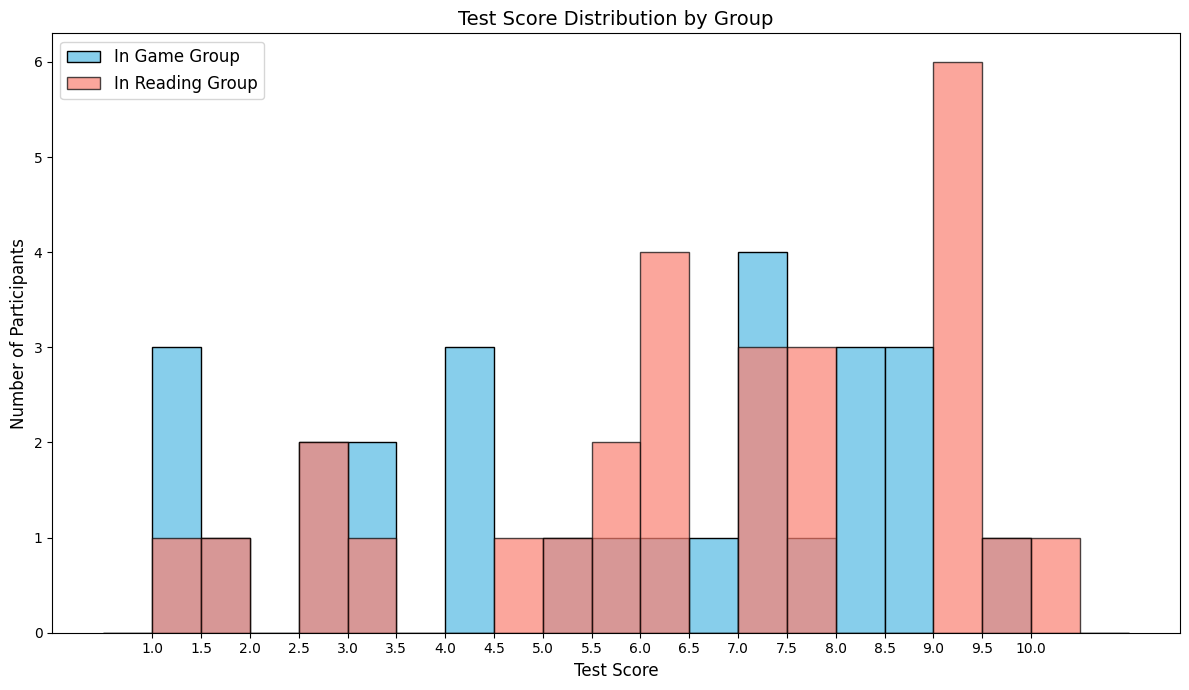

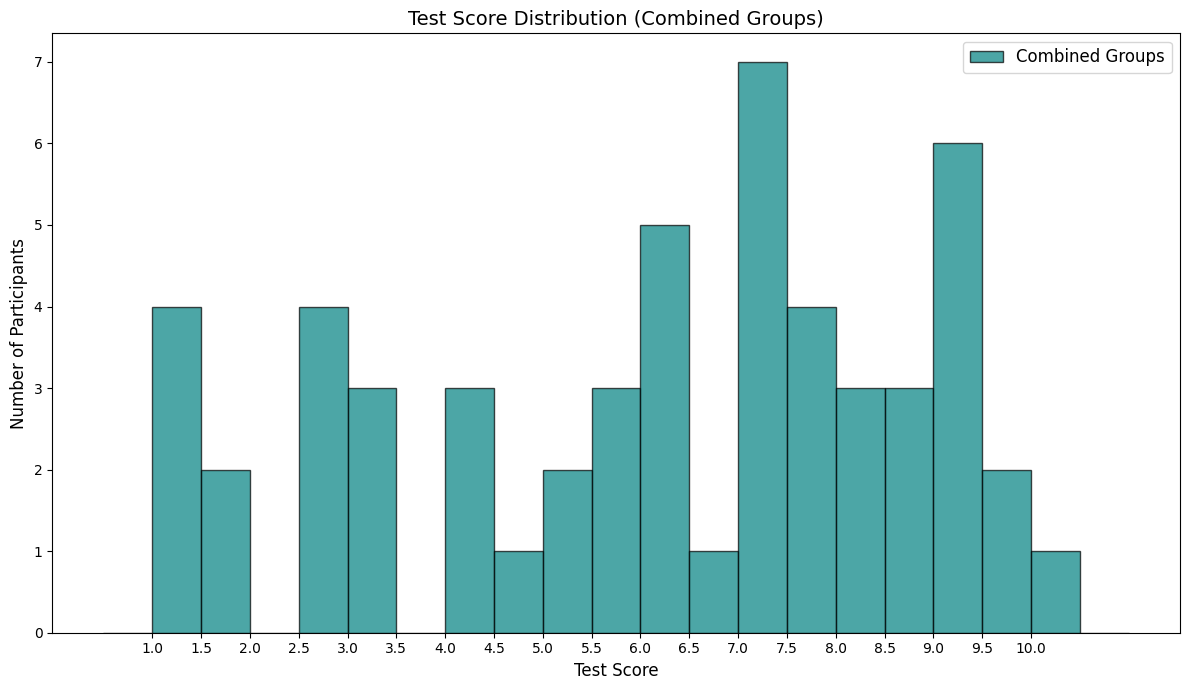

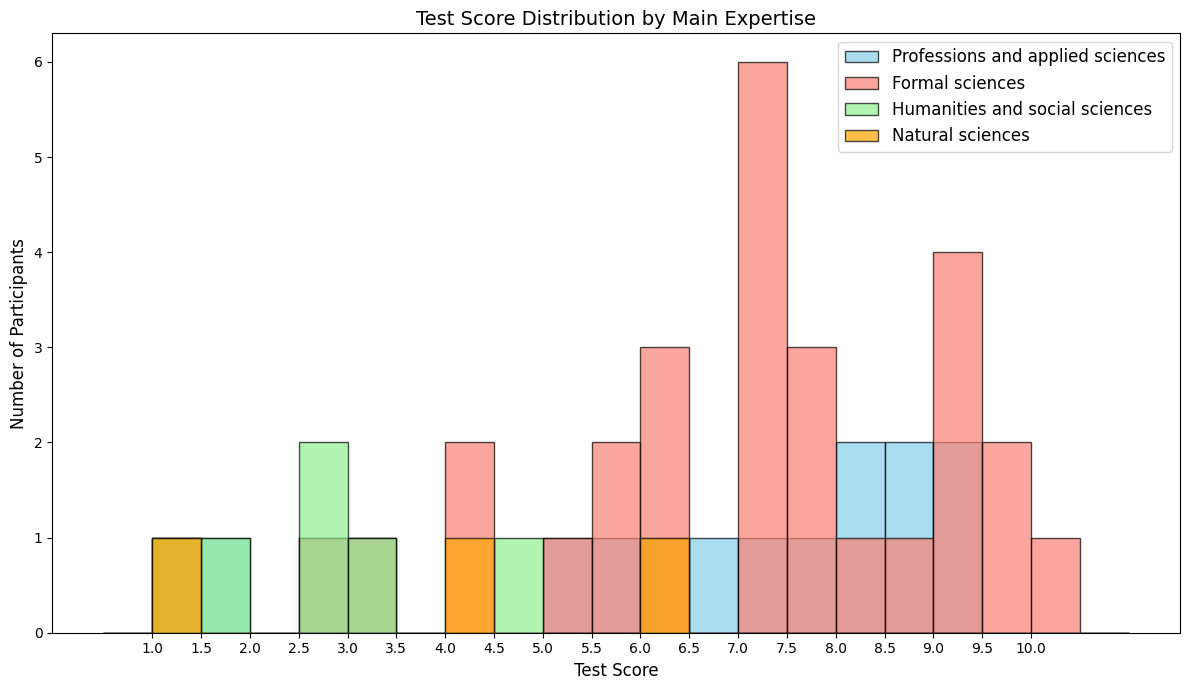

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Extract scores based on group
scores_in_game_group = [
    grade(participant_data["test"]["score"])
    for participant_data in result.values()
    if participant_data["in_game_group"]
]
scores_in_reading_group = [
    grade(participant_data["test"]["score"])
    for participant_data in result.values()
    if not participant_data["in_game_group"]
]

# Define the number of bins for the histogram
all_scores = scores_in_game_group + scores_in_reading_group
bins = np.arange(min(all_scores), max(all_scores) + 2, step=0.5) - 0.5  # Create bins with a slight offset

# Plot histograms
plt.figure(figsize=(12, 7))

# Print
print("Game group")
print(scores_in_game_group)
print("Reading group")
print(scores_in_reading_group)

# Plot histograms for both groups
plt.hist(scores_in_game_group, bins=bins, alpha=1, label='In Game Group', color='skyblue', edgecolor='black')
plt.hist(scores_in_reading_group, bins=bins, alpha=0.7, label='In Reading Group', color='salmon', edgecolor='black')

# Add labels, title, and legend
plt.xlabel("Test Score", fontsize=12)
plt.ylabel("Number of Participants", fontsize=12)
plt.title("Test Score Distribution by Group", fontsize=14)

# Adjust the x-ticks to align with the bins
plt.xticks(np.arange(min(all_scores), max(all_scores) + 0.5, 0.5), fontsize=10)

plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

## COMBINE SCORES
# Combine the scores from both groups
combined_scores = scores_in_game_group + scores_in_reading_group

# Define the number of bins for the histogram
all_scores = combined_scores
bins = np.arange(min(all_scores), max(all_scores) + 2, step=0.5) - 0.5  # Create bins with a slight offset

# Plot histograms
plt.figure(figsize=(12, 7))

# Plot the combined histogram
plt.hist(combined_scores, bins=bins, alpha=0.7, label='Combined Groups', color='teal', edgecolor='black')

# Add labels, title, and legend
plt.xlabel("Test Score", fontsize=12)
plt.ylabel("Number of Participants", fontsize=12)
plt.title("Test Score Distribution (Combined Groups)", fontsize=14)

# Adjust the x-ticks to align with the bins
plt.xticks(np.arange(min(all_scores), max(all_scores) + 0.5, 0.5), fontsize=10)

plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

## MAIN EXPERTISE
# Extract scores based on main_expertise
expertise_groups = {}
for participant_data in result.values():
    expertise = participant_data["main_expertise"]
    score = grade(participant_data["test"]["score"])
    if expertise not in expertise_groups:
        expertise_groups[expertise] = []
    expertise_groups[expertise].append(score)

# Define the number of bins for the histogram
all_scores = [score for scores in expertise_groups.values() for score in scores]
bins = np.arange(min(all_scores), max(all_scores) + 2, step=0.5) - 0.5  # Create bins with a slight offset

# Plot histograms
plt.figure(figsize=(12, 7))

# Plot histograms for each expertise group
colors = ['skyblue', 'salmon', 'lightgreen', 'orange']  # Example colors
for idx, (expertise, scores) in enumerate(expertise_groups.items()):
    plt.hist(scores,
             bins=bins,
             alpha=0.7,
             label=expertise,
             color=colors[idx % len(colors)],
             edgecolor='black',
             histtype='bar',
             linewidth=1,
             )

# Add labels, title, and legend
plt.xlabel("Test Score", fontsize=12)
plt.ylabel("Number of Participants", fontsize=12)
plt.title("Test Score Distribution by Main Expertise", fontsize=14)

# Adjust the x-ticks to align with the bins
plt.xticks(np.arange(min(all_scores), max(all_scores) + 0.5, 0.5), fontsize=10)

plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()



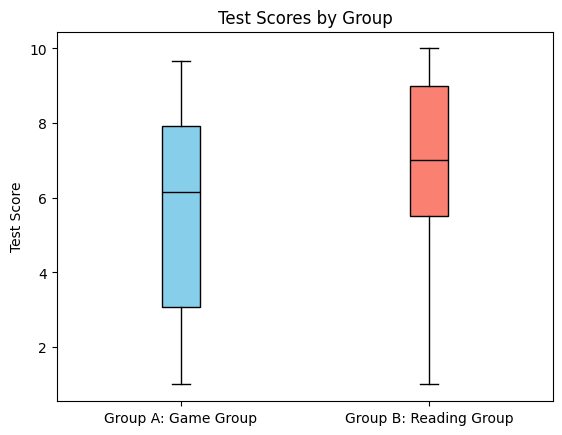

Sufficient scores Group A: 15, which is 55.56% people passed.
Sufficient scores Group B: 20, which is 74.07% people passed.


In [24]:
import matplotlib.pyplot as plt

# Step 1: Initialize lists for scores
in_game_scores = []
not_in_game_scores = []

# Step 2: Extract scores and group by in_game_group
for participant_id, data in result.items():
    test_data = data.get("test", {})
    score = grade(test_data.get("score"))  # Extract the 'score' field
    if isinstance(score, (int, float)):  # Ensure score is a number
        if data["in_game_group"]:
            in_game_scores.append(score)
        else:
            not_in_game_scores.append(score)

# Step 3: Prepare data for the boxplot
data = [in_game_scores, not_in_game_scores]
labels = ["Group A: Game Group", "Group B: Reading Group"]

# Step 4: Create the boxplot
box = plt.boxplot(data, tick_labels=labels, patch_artist=True)

# Customize the first box (index 0)
box['boxes'][0].set(facecolor='skyblue', edgecolor='black')

# Customize the second box (index 1)
box['boxes'][1].set(facecolor='salmon', edgecolor='black')

# Customize the median line colors
box['medians'][0].set(color='black')
box['medians'][1].set(color='black')

# Step 5: Add titles and labels
plt.title("Test Scores by Group")
plt.ylabel("Test Score")
# plt.xlabel("Group")

# Step 6: Display the plot
plt.savefig("graphs/test_scores_by_group_box_plot.svg", format="svg")
plt.show()

# Count sufficient scores
sufficient_games = 0
for score_game in in_game_scores:
    if score_game >= 5.5:
        sufficient_games += 1
print(f"Sufficient scores Group A: {sufficient_games}, which is {sufficient_games / len(in_game_scores) * 100:0.2f}% people passed.")
sufficient_readings = 0
for score_reading in not_in_game_scores:
    if score_reading >= 5.5:
        sufficient_readings += 1
print(f"Sufficient scores Group B: {sufficient_readings}, which is {sufficient_readings / len(not_in_game_scores) * 100:.2f}% people passed.")


In [25]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro
import numpy as np
from statsmodels.stats.power import TTestIndPower

# Step 1: Detect Outliers
def detect_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return [x for x in data if x < lower_bound or x > upper_bound]

# Detect outliers
in_game_outliers = detect_outliers(in_game_scores)
not_in_game_outliers = detect_outliers(not_in_game_scores)

print("Outliers:")
print(f"In Game Group: {in_game_outliers}")
print(f"Not In Game Group: {not_in_game_outliers}")

# Step 2: Check for Normality
shapiro_in_game = shapiro(in_game_scores)
shapiro_not_in_game = shapiro(not_in_game_scores)

print("\nShapiro-Wilk Test Results:")
print(f"In Game Group: W={shapiro_in_game.statistic}, p={shapiro_in_game.pvalue}")
print(f"Not In Game Group: W={shapiro_not_in_game.statistic}, p={shapiro_not_in_game.pvalue}")

# Step 3: Perform the Appropriate Test
if shapiro_in_game.pvalue > 0.05 and shapiro_not_in_game.pvalue > 0.05:
    # Both groups are normally distributed, use t-test
    t_stat, t_pvalue = ttest_ind(in_game_scores, not_in_game_scores, equal_var=False)
    print("\nT-Test Results:")
    print(f"T-Statistic: {t_stat}, p-value: {t_pvalue}")
    if t_pvalue < 0.05:
        print("There is a statistically significant difference between the groups.")
    else:
        print("There is no statistically significant difference.")
else:
    # Use Mann-Whitney U test
    u_stat, u_pvalue = mannwhitneyu(in_game_scores, not_in_game_scores, alternative='two-sided')
    print("\nMann-Whitney U Test Results:")
    print(f"U-Statistic: {u_stat}, p-value: {u_pvalue}")
    if u_pvalue < 0.05:
        print("There is a statistically significant difference between the groups.")
    else:
        print("There is no statistically significant difference.")

# Effect size
mean_diff = np.mean(in_game_scores) - np.mean(not_in_game_scores)
pooled_sd = np.sqrt(((len(in_game_scores) - 1) * np.var(in_game_scores) +
                     (len(not_in_game_scores) - 1) * np.var(not_in_game_scores)) /
                    (len(in_game_scores) + len(not_in_game_scores) - 2))
cohen_d = mean_diff / pooled_sd
print(f"Cohen's d: {cohen_d}")

# Power calculation FOR T-TEST only
effect_size = cohen_d  # Use the Cohen's d value from your script
alpha = 0.05           # Significance level
n1 = len(in_game_scores)  # Sample size of group 1
n2 = len(not_in_game_scores)  # Sample size of group 2

# Calculate power
analysis = TTestIndPower()
power = analysis.power(effect_size=effect_size, nobs1=n1, alpha=alpha, ratio=n2/n1)
print(f"Power of the t-test: {power}")

Outliers:
In Game Group: []
Not In Game Group: []

Shapiro-Wilk Test Results:
In Game Group: W=0.9269113486053293, p=0.058074204061893564
Not In Game Group: W=0.9294648790139044, p=0.06705410554611321

T-Test Results:
T-Statistic: -1.4472036550162837, p-value: 0.15386706184651588
There is no statistically significant difference.
Cohen's d: -0.4013820757077007
Power of the t-test: 0.30451804645635244


In [26]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro
import numpy as np

# Step 1: Detect Outliers
def detect_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return [x for x in data if x < lower_bound or x > upper_bound]

def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return [x for x in data if lower_bound <= x <= upper_bound]

# Detect outliers
in_game_outliers = detect_outliers(in_game_scores)
not_in_game_outliers = detect_outliers(not_in_game_scores)

print("Outliers:")
print(f"In Game Group: {in_game_outliers}")
print(f"Not In Game Group: {not_in_game_outliers}")

# Remove outliers
in_game_scores_cleaned = remove_outliers(in_game_scores)
not_in_game_scores_cleaned = remove_outliers(not_in_game_scores)

print("\nCleaned Data:")
print(f"In Game Group: {in_game_scores_cleaned}")
print(f"Not In Game Group: {not_in_game_scores_cleaned}")

# Step 2: Check for Normality
shapiro_in_game = shapiro(in_game_scores_cleaned)
shapiro_not_in_game = shapiro(not_in_game_scores_cleaned)

print("\nShapiro-Wilk Test Results:")
print(f"In Game Group: W={shapiro_in_game.statistic}, p={shapiro_in_game.pvalue}")
print(f"Not In Game Group: W={shapiro_not_in_game.statistic}, p={shapiro_not_in_game.pvalue}")

# Step 3: Perform the Appropriate Test
if shapiro_in_game.pvalue > 0.05 and shapiro_not_in_game.pvalue > 0.05:
    # Both groups are normally distributed, use t-test
    t_stat, t_pvalue = ttest_ind(in_game_scores_cleaned, not_in_game_scores_cleaned, equal_var=False)
    print("\nT-Test Results:")
    print(f"T-Statistic: {t_stat}, p-value: {t_pvalue}")
    if t_pvalue < 0.05:
        print("There is a statistically significant difference between the groups.")
    else:
        print("There is no statistically significant difference.")
else:
    # Use Mann-Whitney U test
    u_stat, u_pvalue = mannwhitneyu(in_game_scores_cleaned, not_in_game_scores_cleaned, alternative='two-sided')
    print("\nMann-Whitney U Test Results:")
    print(f"U-Statistic: {u_stat}, p-value: {u_pvalue}")
    if u_pvalue < 0.05:
        print("There is a statistically significant difference between the groups.")
    else:
        print("There is no statistically significant difference.")


Outliers:
In Game Group: []
Not In Game Group: []

Cleaned Data:
In Game Group: [6.666666666666667, 2.833333333333333, 8.0, 8.666666666666668, 7.0, 3.1666666666666665, 5.5, 5.0, 1.3333333333333333, 8.0, 1.0, 8.166666666666666, 2.6666666666666665, 1.6666666666666665, 4.333333333333333, 8.5, 6.166666666666667, 7.0, 4.166666666666667, 7.833333333333334, 7.0, 4.0, 3.0, 9.666666666666666, 7.333333333333334, 1.0, 8.5]
Not In Game Group: [6.333333333333333, 5.166666666666667, 2.833333333333333, 7.833333333333334, 5.833333333333334, 7.0, 9.5, 7.5, 7.0, 5.833333333333334, 4.666666666666666, 7.333333333333334, 1.8333333333333333, 6.0, 9.0, 3.0, 9.0, 1.0, 9.166666666666668, 7.666666666666666, 9.0, 9.333333333333334, 10.0, 9.0, 6.0, 6.166666666666667, 2.833333333333333]

Shapiro-Wilk Test Results:
In Game Group: W=0.9269113486053293, p=0.058074204061893564
Not In Game Group: W=0.9294648790139044, p=0.06705410554611321

T-Test Results:
T-Statistic: -1.4472036550162837, p-value: 0.15386706184651588


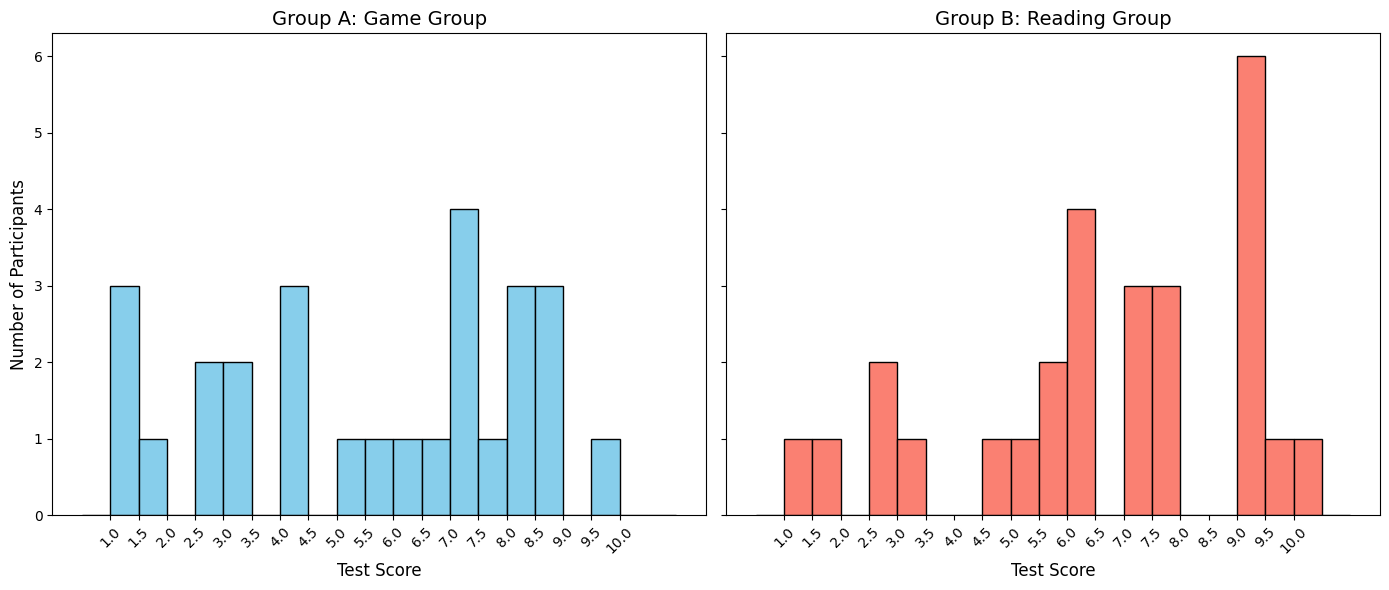

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the result dictionary and grade function are already defined

# Extract scores based on group
scores_in_game_group = [
    grade(participant_data["test"]["score"])
    for participant_data in result.values()
    if participant_data["in_game_group"]
]
scores_in_reading_group = [
    grade(participant_data["test"]["score"])
    for participant_data in result.values()
    if not participant_data["in_game_group"]
]

# Define the number of bins for the histogram
all_scores = scores_in_game_group + scores_in_reading_group
bins = np.arange(min(all_scores), max(all_scores) + 2, step=0.5) - 0.5  # Create bins with a slight offset

# Create subplots for side-by-side graphs
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot histogram for "In Game Group"
axes[0].hist(scores_in_game_group, bins=bins, alpha=1, color='skyblue', edgecolor='black')
axes[0].set_title("Group A: Game Group", fontsize=14)
axes[0].set_xlabel("Test Score", fontsize=12)
axes[0].set_ylabel("Number of Participants", fontsize=12)
axes[0].set_xticks(np.arange(min(all_scores), max(all_scores) + 0.5, 0.5))
axes[0].tick_params(axis='x', labelrotation=45, labelsize=10)

# Plot histogram for "Reading Group"
axes[1].hist(scores_in_reading_group, bins=bins, alpha=1, color='salmon', edgecolor='black')
axes[1].set_title("Group B: Reading Group", fontsize=14)
axes[1].set_xlabel("Test Score", fontsize=12)
axes[1].set_xticks(np.arange(min(all_scores), max(all_scores) + 0.5, 0.5))
axes[1].tick_params(axis='x', labelrotation=45, labelsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("graphs/test_scores_by_group_histogram.svg", format="svg")
plt.show()

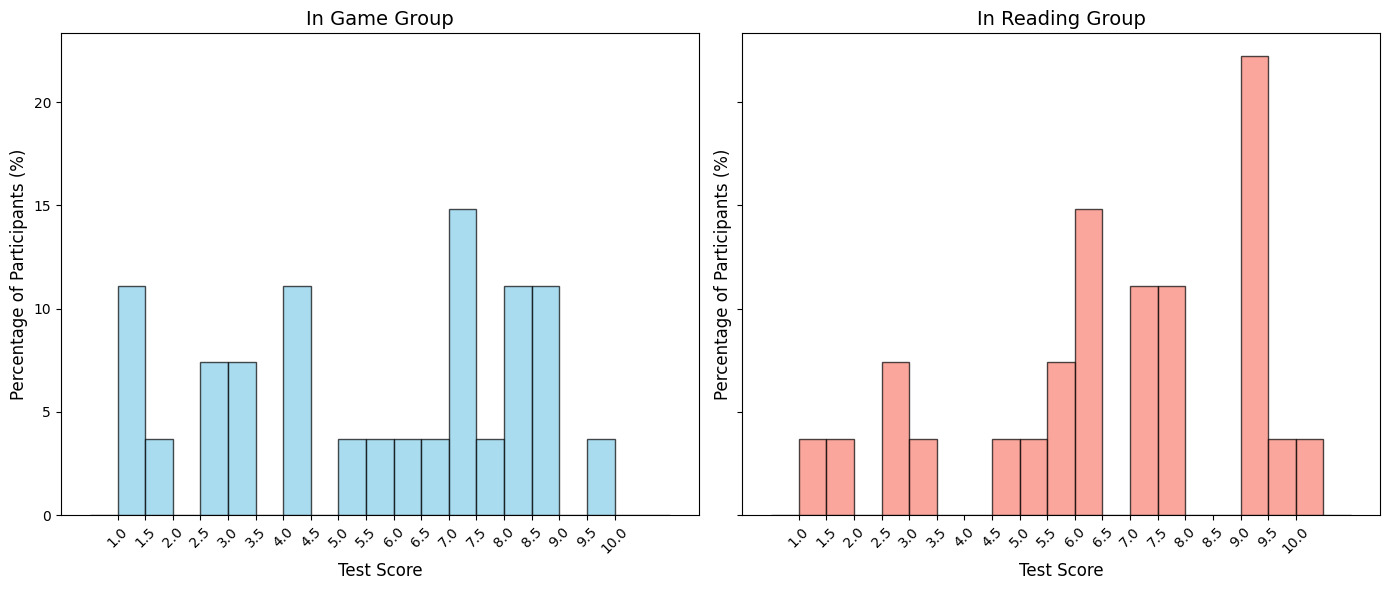

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the result dictionary and grade function are already defined

# Extract scores based on group
scores_in_game_group = [
    grade(participant_data["test"]["score"])
    for participant_data in result.values()
    if participant_data["in_game_group"]
]
scores_in_reading_group = [
    grade(participant_data["test"]["score"])
    for participant_data in result.values()
    if not participant_data["in_game_group"]
]

# Define the number of bins for the histogram
all_scores = scores_in_game_group + scores_in_reading_group
bins = np.arange(min(all_scores), max(all_scores) + 2, step=0.5) - 0.5  # Create bins with a slight offset

# Create subplots for side-by-side graphs
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)


# Function to plot percentage histograms
def plot_percentage_histogram(axes, idx, scores, bins, group_name, color):
    # Calculate the number of participants in each bin
    counts, _ = np.histogram(scores, bins=bins)

    # Calculate the percentage for each bin
    total_count = len(scores)
    percentages = (counts / total_count) * 100

    # Plot the histogram with percentages
    axes[idx].bar(bins[:-1], percentages, width=0.5, alpha=0.7, color=color, edgecolor='black', align='edge')
    axes[idx].set_title(group_name, fontsize=14)
    axes[idx].set_xlabel("Test Score", fontsize=12)
    axes[idx].set_ylabel("Percentage of Participants (%)", fontsize=12)
    axes[idx].set_xticks(np.arange(min(all_scores), max(all_scores) + 0.5, 0.5))
    axes[idx].tick_params(axis='x', labelrotation=45, labelsize=10)


# Plot histogram for "In Game Group"
plot_percentage_histogram(axes, 0, scores_in_game_group, bins, "In Game Group", 'skyblue')

# Plot histogram for "Reading Group"
plot_percentage_histogram(axes, 1, scores_in_reading_group, bins, "In Reading Group", 'salmon')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


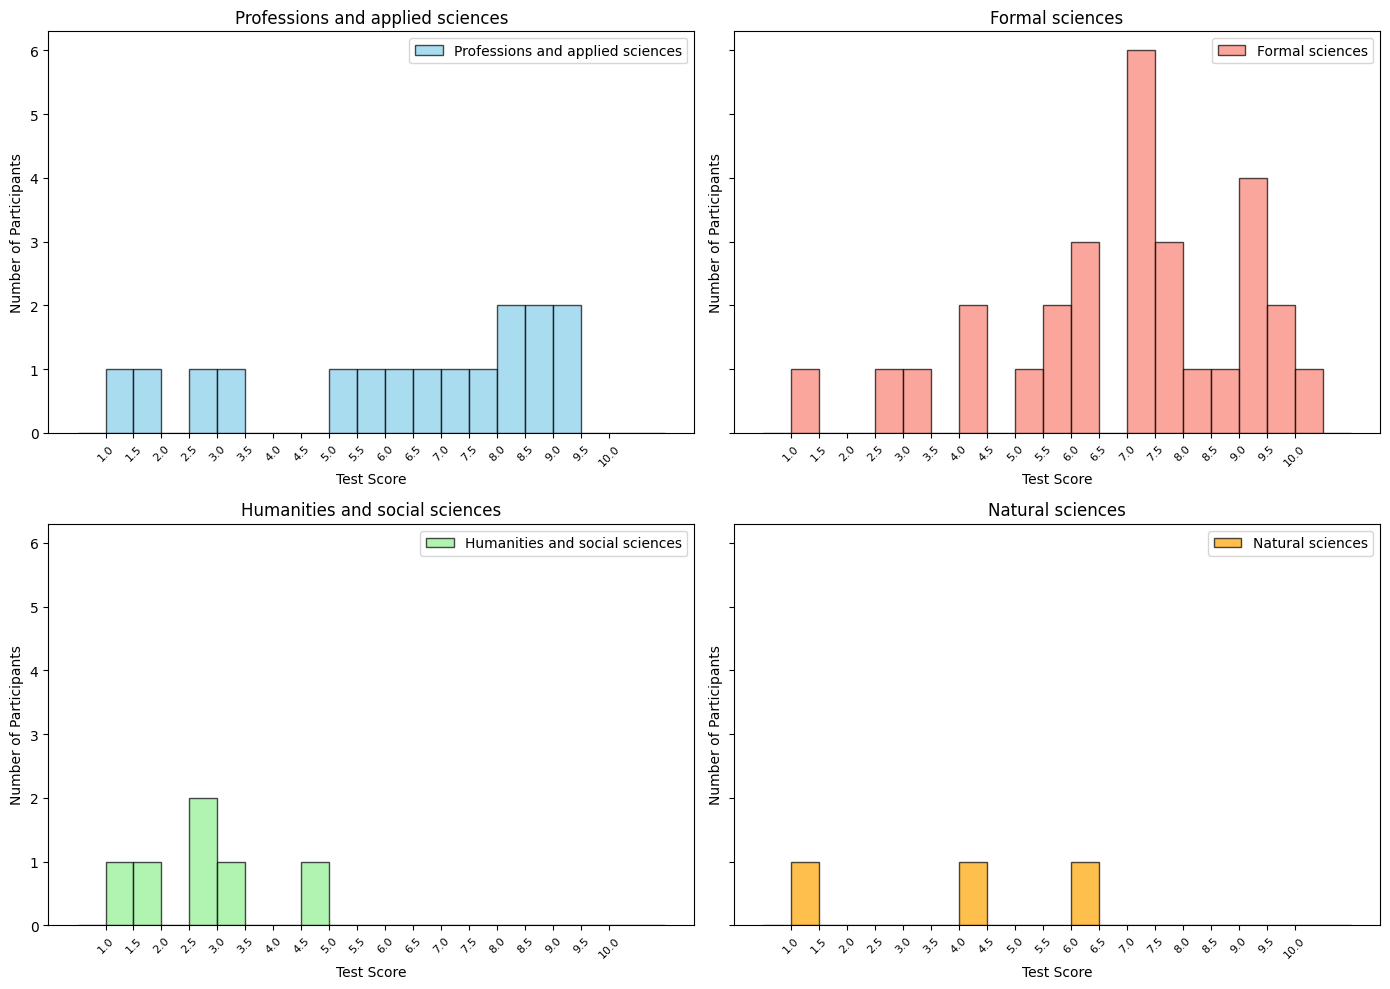

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Extract scores based on main_expertise
expertise_groups = {}
for participant_data in result.values():
    expertise = participant_data["main_expertise"]
    score = grade(participant_data["test"]["score"])
    if expertise not in expertise_groups:
        expertise_groups[expertise] = []
    expertise_groups[expertise].append(score)

# Define the number of bins for the histogram
all_scores = [score for scores in expertise_groups.values() for score in scores]
bins = np.arange(min(all_scores), max(all_scores) + 2, step=0.5) - 0.5  # Create bins with a slight offset

# Create subplots for a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot histograms for each expertise group
colors = ['skyblue', 'salmon', 'lightgreen', 'orange']  # Example colors

for idx, (expertise, scores) in enumerate(expertise_groups.items()):
    ax = axes[idx]
    ax.hist(scores,
            bins=bins,
            alpha=0.7,
            label=expertise,
            color=colors[idx % len(colors)],
            edgecolor='black',
            histtype='bar',
            linewidth=1,
            )
    ax.set_title(expertise, fontsize=12)
    ax.set_xlabel("Test Score", fontsize=10)
    ax.set_ylabel("Number of Participants", fontsize=10)
    ax.legend(fontsize=10)
    ax.set_xticks(np.arange(min(all_scores), max(all_scores) + 0.5, 0.5))
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [30]:
from scipy import stats

# Step 1: Check for normality for each expertise group using Shapiro-Wilk test
normality_results = {}
for expertise, scores in expertise_groups.items():
    stat, p_value = stats.shapiro(scores)
    normality_results[expertise] = p_value
    print(f"Normality test for {expertise} p-value: {p_value}")

# Step 2: Check for equality of variances using Levene's test
all_scores_by_expertise = list(expertise_groups.values())
levene_stat, levene_p_value = stats.levene(*all_scores_by_expertise)
print(f"Levene's test for equality of variances p-value: {levene_p_value}")

# Step 3: Perform statistical tests based on normality and equality of variances
if all(p_value > 0.05 for p_value in normality_results.values()) and levene_p_value > 0.05:
    # Data is normally distributed and variances are equal, use ANOVA
    print("Data is normally distributed and variances are equal. Performing one-way ANOVA.")
    f_stat, p_value_anova = stats.f_oneway(*all_scores_by_expertise)
    print(f"ANOVA result: F={f_stat}, p={p_value_anova}")

    if p_value_anova < 0.05:
        print("Conclusion: There is a statistically significant difference in test scores between the expertise groups.")
    else:
        print("Conclusion: There is no statistically significant difference in test scores between the expertise groups.")
else:
    # Data is not normally distributed or variances are unequal, use Kruskal-Wallis H test
    print("Data is not normally distributed or variances are unequal. Performing Kruskal-Wallis H test.")
    h_stat, p_value_kw = stats.kruskal(*all_scores_by_expertise)
    print(f"Kruskal-Wallis result: H={h_stat}, p={p_value_kw}")

    if p_value_kw < 0.05:
        print("Conclusion: There is a statistically significant difference in test scores between the expertise groups.")
    else:
        print("Conclusion: There is no statistically significant difference in test scores between the expertise groups.")


Normality test for Professions and applied sciences p-value: 0.0470240735132304
Normality test for Formal sciences p-value: 0.1381151833475613
Normality test for Humanities and social sciences p-value: 0.7860317460148358
Normality test for Natural sciences p-value: 0.8105108151241395
Levene's test for equality of variances p-value: 0.3501832082798371
Data is not normally distributed or variances are unequal. Performing Kruskal-Wallis H test.
Kruskal-Wallis result: H=12.49854308402712, p=0.0058566308942752
Conclusion: There is a statistically significant difference in test scores between the expertise groups.


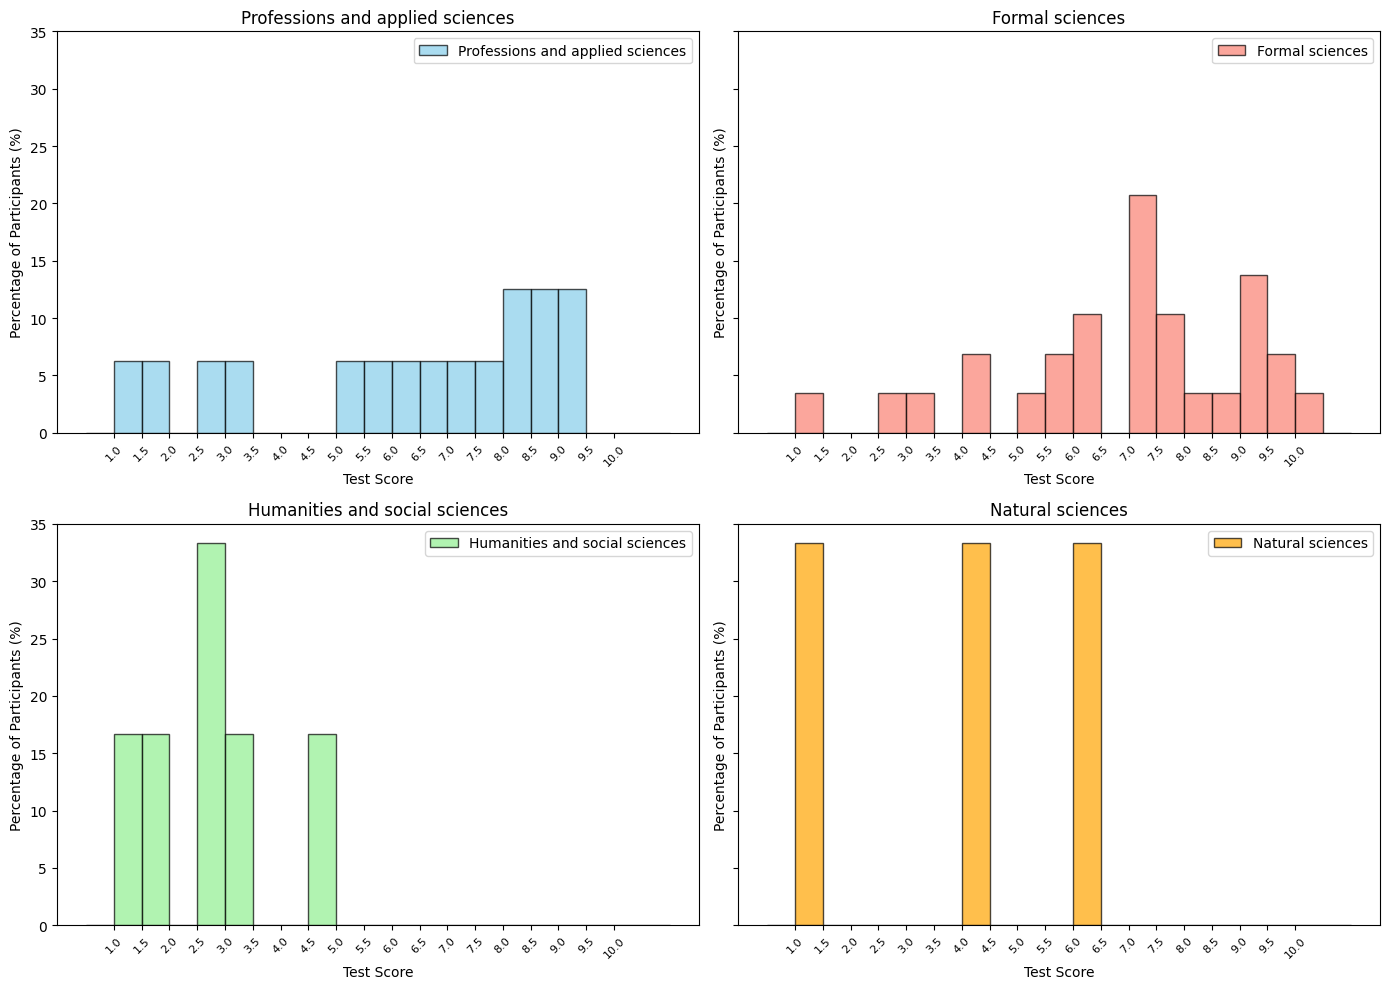

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Extract scores based on main_expertise
expertise_groups = {}
for participant_data in result.values():
    expertise = participant_data["main_expertise"]
    score = grade(participant_data["test"]["score"])
    if expertise not in expertise_groups:
        expertise_groups[expertise] = []
    expertise_groups[expertise].append(score)

# Define the number of bins for the histogram
all_scores = [score for scores in expertise_groups.values() for score in scores]
bins = np.arange(min(all_scores), max(all_scores) + 2, step=0.5) - 0.5  # Create bins with a slight offset

# Create subplots for a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot histograms for each expertise group
colors = ['skyblue', 'salmon', 'lightgreen', 'orange']  # Example colors

for idx, (expertise, scores) in enumerate(expertise_groups.items()):
    ax = axes[idx]

    # Calculate the number of participants in each bin
    counts, _ = np.histogram(scores, bins=bins)

    # Calculate the percentage for each bin
    total_count = len(scores)
    percentages = (counts / total_count) * 100

    ax.bar(bins[:-1], percentages, width=0.5, alpha=0.7, label=expertise, color=colors[idx % len(colors)],
           edgecolor='black', align='edge')

    ax.set_title(expertise, fontsize=12)
    ax.set_xlabel("Test Score", fontsize=10)
    ax.set_ylabel("Percentage of Participants (%)", fontsize=10)
    ax.legend(fontsize=10)
    ax.set_xticks(np.arange(min(all_scores), max(all_scores) + 0.5, 0.5))
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


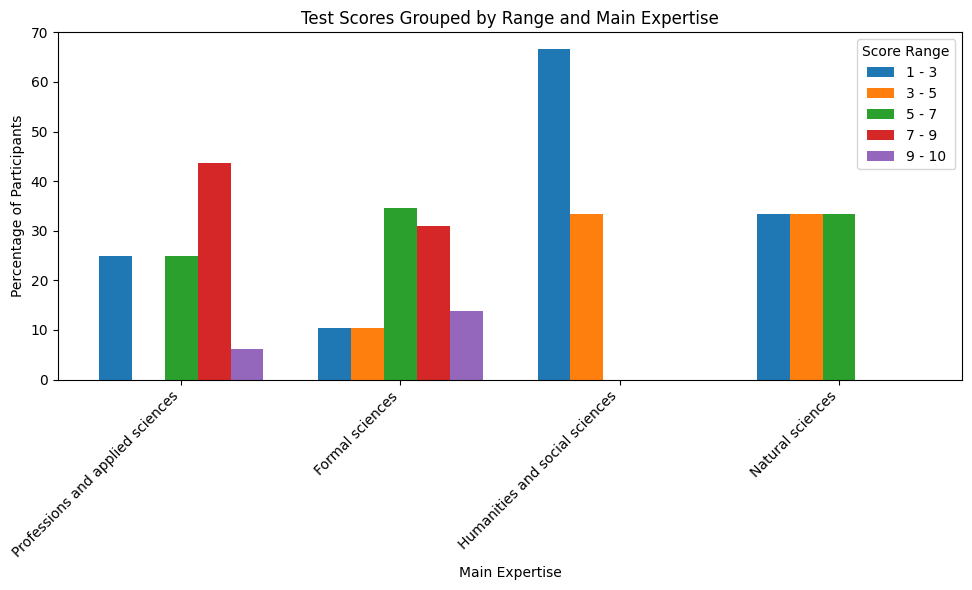

In [32]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Assuming the result dictionary from the database query is available
# result is the dictionary containing participant data as shown in the original code

# Step 1: Define the score ranges explicitly (6 bins, 1-2, 3-4, ..., 9-10)
score_ranges = [(i, i + 2) for i in range(1, 10, 2)]  # 1-3, 3-5, ..., 9-10
score_ranges[-1] = (score_ranges[-1][0], 10)  # Ensure the last bin includes 10

# Step 2: Prepare the data to group test scores by expertise
expertise_score_counts = defaultdict(lambda: defaultdict(int))
total_expertise_counts = defaultdict(int)  # To store total participants per expertise

# Iterate through the results and extract test scores
for participant_id, data in result.items():
    main_expertise = data.get("main_expertise")
    if main_expertise:
        # Extract the total score for the test
        score = grade(data["test"]["score"])

        # Increment total count for the expertise group
        total_expertise_counts[main_expertise] += 1

        # Find the range for this score
        for start, end in score_ranges:
            if start <= score <= end:
                expertise_score_counts[main_expertise][(start, end)] += 1
                break

# Step 3: Prepare the data for plotting
expertise_labels = list(total_expertise_counts.keys())
range_labels = [f"{start} - {end}" for start, end in score_ranges]
range_data = {label: [] for label in range_labels}

# Calculate percentages for each expertise and range
for expertise in expertise_labels:
    total_in_expertise = total_expertise_counts[expertise]
    for range_label in range_labels:
        # Parse range_label to get the start and end of the range
        start, end = map(int, range_label.split(' - '))
        count = expertise_score_counts[expertise].get((start, end), 0)
        percentage = (count / total_in_expertise * 100) if total_in_expertise > 0 else 0
        range_data[range_label].append(percentage)

# Step 4: Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Generate the bar positions for each expertise
bar_width = 0.15
index = range(len(expertise_labels))

# Plot bars for each score range
for i, range_label in enumerate(range_labels):
    ax.bar(
        [x + bar_width * i for x in index],
        range_data[range_label],
        bar_width,
        label=range_label
    )

# Step 5: Customize the chart
ax.set_xlabel('Main Expertise')
ax.set_ylabel('Percentage of Participants')
ax.set_title('Test Scores Grouped by Range and Main Expertise')
ax.set_xticks([x + bar_width * (len(range_labels) / 2 - 0.5) for x in index])
ax.set_xticklabels(expertise_labels)
ax.legend(title="Score Range")

# Step 6: Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


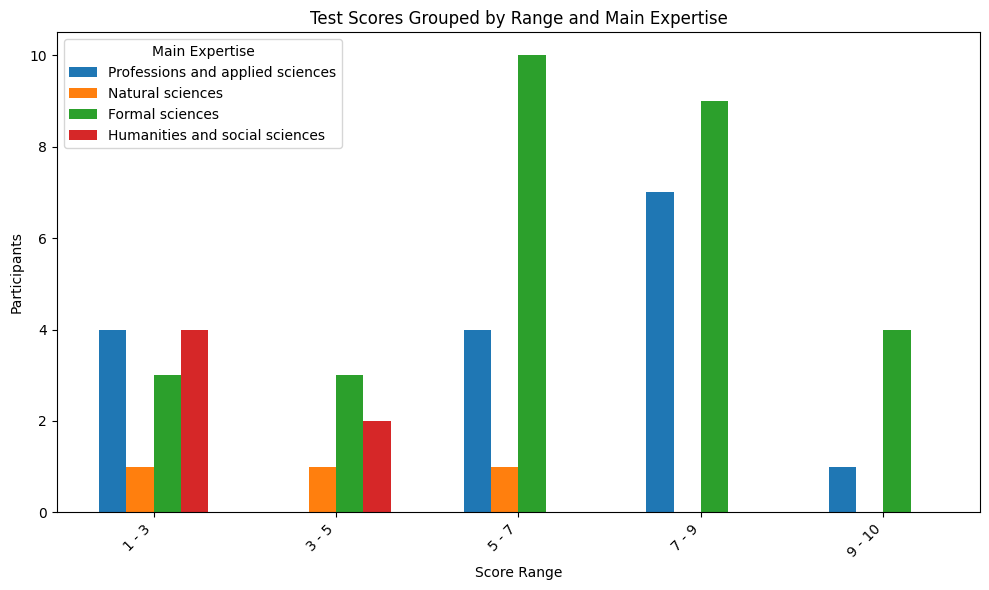

In [33]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Assuming the result dictionary from the database query is available
# result is the dictionary containing participant data as shown in the original code

# Step 1: Extract all test scores and calculate the min and max score
all_scores = []

# Collect all test scores from the data
for participant_id, data in result.items():
    score = grade(data["test"]["score"])
    all_scores.append(score)

# Calculate the min and max score
min_score = min(all_scores)
max_score = max(all_scores)

# Step 2: Define the number of bins (ranges) you want (6 ranges in this case)
num_bins = 6
range_size = (max_score - min_score) / num_bins

# Create the score ranges
score_ranges = [(i, i + 2) for i in range(1, 10, 2)]  # 1-2, 2-3, ..., 9-10
score_ranges[-1] = (score_ranges[-1][0], 10)  # Ensure the last bin includes 10

# Step 3: Prepare the data to group test scores by expertise
expertise_score_counts = defaultdict(lambda: defaultdict(int))

# Iterate through the results and extract test scores
for participant_id, data in result.items():
    main_expertise = data.get("main_expertise")
    if main_expertise:
        # Extract the total score for the test
        score = grade(data["test"]["score"])

        # Find the range for this score
        for start, end in score_ranges:
            if start <= score <= end:
                expertise_score_counts[(start, end)][main_expertise] += 1
                break

# Step 4: Prepare the data for plotting
range_labels = [f"{start} - {end}" for start, end in score_ranges]
expertise_labels = list({expertise for ranges in expertise_score_counts.values() for expertise in ranges})

# Initialize a dictionary to hold counts for each range and expertise
range_data = {label: [0] * len(expertise_labels) for label in range_labels}

# Fill range_data with counts for each expertise
for i, range_label in enumerate(range_labels):
    start, end = map(int, range_label.split(' - '))
    for j, expertise in enumerate(expertise_labels):
        count = expertise_score_counts.get((start, end), {}).get(expertise, 0)
        range_data[range_label][j] = count

# Step 5: Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Generate the bar positions for each range
bar_width = 0.15
index = range(len(range_labels))

# Plot bars for each expertise in each range
for i, expertise in enumerate(expertise_labels):
    ax.bar(
        [x + bar_width * i for x in index],
        [range_data[range_label][i] for range_label in range_labels],
        bar_width,
        label=expertise
    )

# Step 6: Customize the chart
ax.set_xlabel('Score Range')
ax.set_ylabel('Participants')
ax.set_title('Test Scores Grouped by Range and Main Expertise')
ax.set_xticks([x + bar_width * (len(expertise_labels) / 2 - 0.5) for x in index])
ax.set_xticklabels(range_labels)
ax.legend(title="Main Expertise")

# Step 7: Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


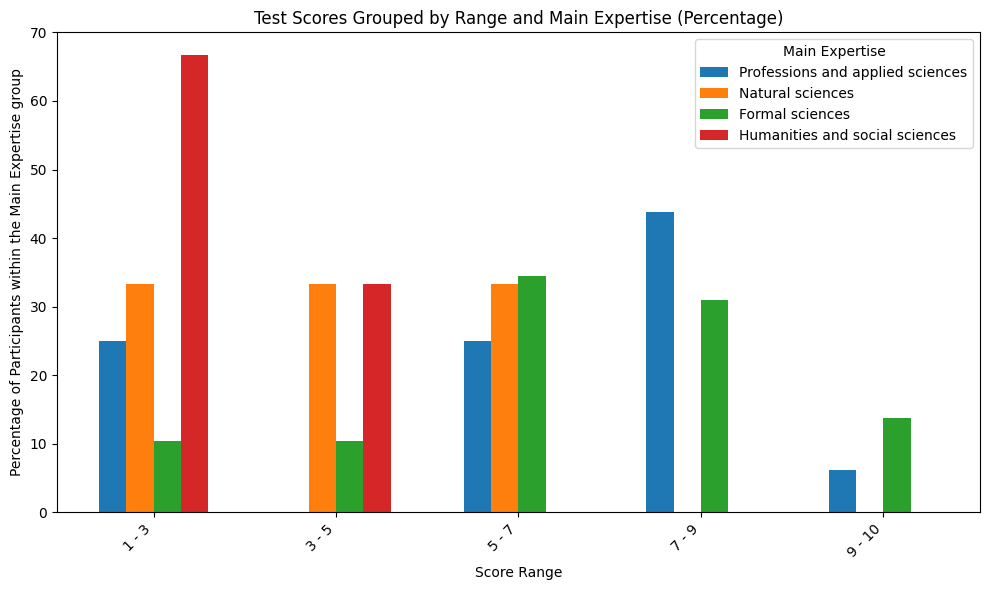

In [34]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Assuming the result dictionary from the database query is available
# result is the dictionary containing participant data as shown in the original code

# Step 1: Extract all test scores and calculate the min and max score
all_scores = []

# Collect all test scores from the data
for participant_id, data in result.items():
    score = data["test"]["score"]
    all_scores.append(score)

# Calculate the min and max score
min_score = min(all_scores)
max_score = max(all_scores)

# Step 2: Define the number of bins (ranges) you want (6 ranges in this case)
num_bins = 6
range_size = (max_score - min_score) / num_bins

# Create the score ranges
score_ranges = [(i, i + 2) for i in range(1, 10, 2)]  # 1-2, 2-3, ..., 9-10
score_ranges[-1] = (score_ranges[-1][0], 10)  # Ensure the last bin includes 10

# Step 3: Prepare the data to group test scores by expertise
expertise_score_counts = defaultdict(lambda: defaultdict(int))
expertise_totals = defaultdict(int)

# Iterate through the results and extract test scores
for participant_id, data in result.items():
    main_expertise = data.get("main_expertise")
    if main_expertise:
        # Extract the total score for the test
        score = grade(data["test"]["score"])

        # Find the range for this score
        for start, end in score_ranges:
            if start <= score <= end:
                expertise_score_counts[(start, end)][main_expertise] += 1
                expertise_totals[main_expertise] += 1
                break

# Step 4: Prepare the data for plotting
range_labels = [f"{start} - {end}" for start, end in score_ranges]
expertise_labels = list({expertise for ranges in expertise_score_counts.values() for expertise in ranges})

# Initialize a dictionary to hold percentages for each range and expertise
range_data = {label: [0] * len(expertise_labels) for label in range_labels}

# Fill range_data with percentages for each expertise
for i, range_label in enumerate(range_labels):
    start, end = map(int, range_label.split(' - '))
    for j, expertise in enumerate(expertise_labels):
        count = expertise_score_counts.get((start, end), {}).get(expertise, 0)
        total = expertise_totals.get(expertise, 0)
        percentage = (count / total * 100) if total > 0 else 0
        range_data[range_label][j] = percentage

# Step 5: Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Generate the bar positions for each range
bar_width = 0.15
index = range(len(range_labels))

# Plot bars for each expertise in each range
for i, expertise in enumerate(expertise_labels):
    ax.bar(
        [x + bar_width * i for x in index],
        [range_data[range_label][i] for range_label in range_labels],
        bar_width,
        label=expertise
    )

# Step 6: Customize the chart
ax.set_xlabel('Score Range')
ax.set_ylabel('Percentage of Participants within the Main Expertise group')
ax.set_title('Test Scores Grouped by Range and Main Expertise (Percentage)')
ax.set_xticks([x + bar_width * (len(expertise_labels) / 2 - 0.5) for x in index])
ax.set_xticklabels(range_labels)
ax.legend(title="Main Expertise")

# Step 7: Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


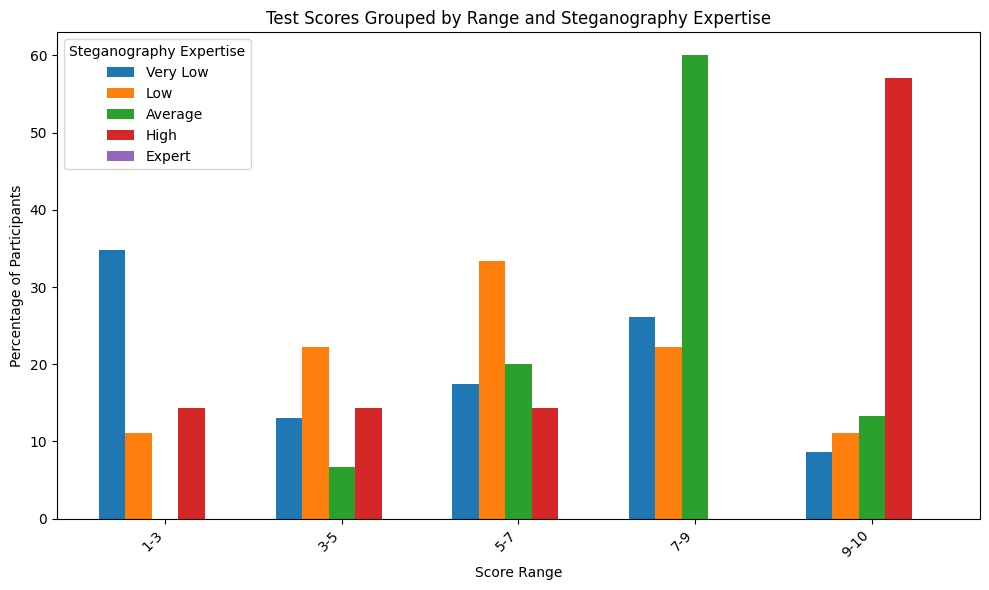

In [35]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Assuming the result dictionary from the database query is available
# result is the dictionary containing participant data as shown in the original code

# Step 1: Define the score ranges explicitly (9 bins between 1 and 10)
score_ranges = [(i, i + 2) for i in range(1, 10, 2)]  # 1-2, 2-3, ..., 9-10
score_ranges[-1] = (score_ranges[-1][0], 10)  # Ensure the last bin includes 10

# Step 2: Prepare the data to group test scores by expertise
expertise_score_counts = defaultdict(lambda: defaultdict(int))
total_expertise_counts = defaultdict(int)  # To store total participants per expertise

# Iterate through the results and extract test scores
for participant_id, data in result.items():
    steganography = data.get("steganography")
    if steganography:
        # Extract the total score for the test
        score = grade(data["test"]["score"])

        # Increment total count for the expertise group
        total_expertise_counts[steganography] += 1

        # Find the range for this score
        for i, (start, end) in enumerate(score_ranges):
            if start <= score < end or (
                    i == len(score_ranges) - 1 and start <= score <= end):  # Include upper bound for last bin
                expertise_score_counts[(start, end)][steganography] += 1
                break

# Step 3: Prepare the data for plotting
range_labels = [f"{start}-{end}" for start, end in score_ranges]
expertise_labels = ["Very Low", "Low", "Average", "High", "Expert"]  # Specific order

# Initialize a dictionary to hold percentages for each range and expertise
range_data = {label: [0] * len(expertise_labels) for label in range_labels}

# Calculate percentages for each range and expertise
for i, range_label in enumerate(range_labels):
    start, end = map(int, range_label.split('-'))
    for j, expertise in enumerate(expertise_labels):
        total_expertise = total_expertise_counts[expertise]
        count = expertise_score_counts.get((start, end), {}).get(expertise, 0)
        range_data[range_label][j] = (count / total_expertise * 100) if total_expertise > 0 else 0

# Step 4: Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Generate the bar positions for each range
bar_width = 0.15
index = range(len(range_labels))

# Plot bars for each expertise in each range
for i, expertise in enumerate(expertise_labels):
    ax.bar(
        [x + bar_width * i for x in index],
        [range_data[range_label][i] for range_label in range_labels],
        bar_width,
        label=expertise
    )

# Step 5: Customize the chart
ax.set_xlabel('Score Range')
ax.set_ylabel('Percentage of Participants')
ax.set_title('Test Scores Grouped by Range and Steganography Expertise')
ax.set_xticks([x + bar_width * (len(expertise_labels) / 2 - 0.5) for x in index])
ax.set_xticklabels(range_labels)
ax.legend(title="Steganography Expertise")

# Step 6: Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


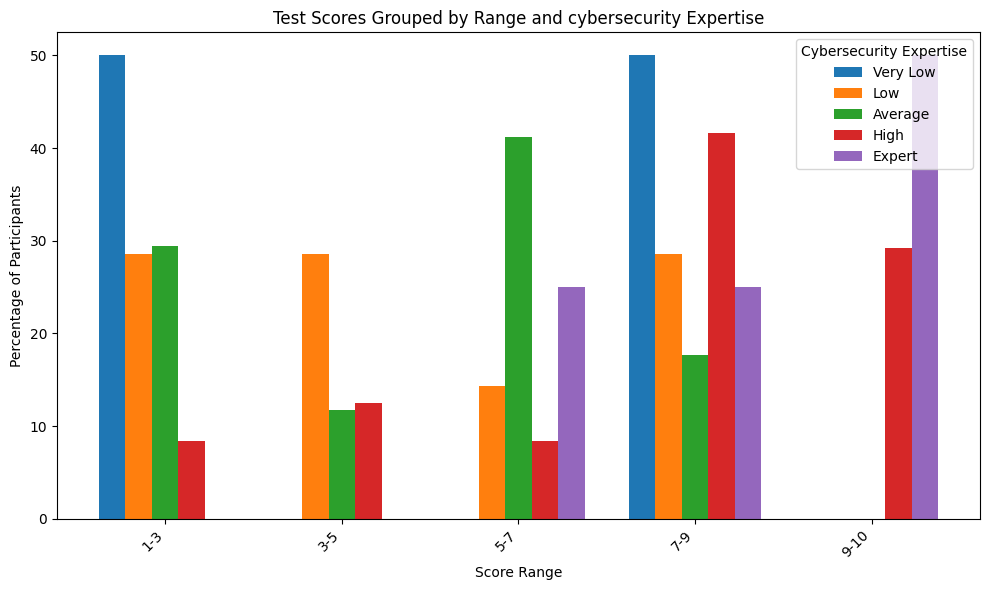

In [36]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Assuming the result dictionary from the database query is available
# result is the dictionary containing participant data as shown in the original code

# Step 1: Define the score ranges explicitly (9 bins between 1 and 10)
score_ranges = [(i, i + 2) for i in range(1, 10, 2)]  # 1-2, 2-3, ..., 9-10
score_ranges[-1] = (score_ranges[-1][0], 10)  # Ensure the last bin includes 10

# Step 2: Prepare the data to group test scores by expertise
expertise_score_counts = defaultdict(lambda: defaultdict(int))
total_expertise_counts = defaultdict(int)  # To store total participants per expertise

# Iterate through the results and extract test scores
for participant_id, data in result.items():
    cybersecurity = data.get("cybersecurity")
    if cybersecurity:
        # Extract the total score for the test
        score = grade(data["test"]["score"])

        # Increment total count for the expertise group
        total_expertise_counts[cybersecurity] += 1

        # Find the range for this score
        for i, (start, end) in enumerate(score_ranges):
            if start <= score < end or (
                    i == len(score_ranges) - 1 and start <= score <= end):  # Include upper bound for last bin
                expertise_score_counts[(start, end)][cybersecurity] += 1
                break

# Step 3: Prepare the data for plotting
range_labels = [f"{start}-{end}" for start, end in score_ranges]
expertise_labels = ["Very Low", "Low", "Average", "High", "Expert"]  # Specific order

# Initialize a dictionary to hold percentages for each range and expertise
range_data = {label: [0] * len(expertise_labels) for label in range_labels}

# Calculate percentages for each range and expertise
for i, range_label in enumerate(range_labels):
    start, end = map(int, range_label.split('-'))
    for j, expertise in enumerate(expertise_labels):
        total_expertise = total_expertise_counts[expertise]
        count = expertise_score_counts.get((start, end), {}).get(expertise, 0)
        range_data[range_label][j] = (count / total_expertise * 100) if total_expertise > 0 else 0

# Step 4: Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Generate the bar positions for each range
bar_width = 0.15
index = range(len(range_labels))

# Plot bars for each expertise in each range
for i, expertise in enumerate(expertise_labels):
    ax.bar(
        [x + bar_width * i for x in index],
        [range_data[range_label][i] for range_label in range_labels],
        bar_width,
        label=expertise
    )

# Step 5: Customize the chart
ax.set_xlabel('Score Range')
ax.set_ylabel('Percentage of Participants')
ax.set_title('Test Scores Grouped by Range and cybersecurity Expertise')
ax.set_xticks([x + bar_width * (len(expertise_labels) / 2 - 0.5) for x in index])
ax.set_xticklabels(range_labels)
ax.legend(title="Cybersecurity Expertise")

# Step 6: Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [37]:
from scipy.stats import spearmanr

# Prepare the data for Spearman's rank correlation
# Map cybersecurity expertise levels to numeric values
expertise_map = {'Very Low': 1, 'Low': 2, 'Average': 3, 'High': 4, 'Expert': 5}

# Create lists of expertise levels and corresponding test scores
expertise_levels = [expertise_map[data['cybersecurity']] for data in result.values() if data.get('cybersecurity')]
test_scores = [grade(data['test']['score']) for data in result.values() if data.get('cybersecurity')]

# Calculate Spearman's rank correlation
corr, p_value = spearmanr(expertise_levels, test_scores)

# Print the results
print(f"Spearman's rank correlation: {corr}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant correlation between cybersecurity expertise and test scores, so a higher cybersecurity expertise is associated with higher test scores.")
else:
    print("There is no statistically significant correlation between cybersecurity expertise and test scores.")

from scipy.stats import kruskal

# Group test scores by cybersecurity expertise levels
expertise_groups = {expertise: [] for expertise in expertise_map.values()}
for participant_data in result.values():
    if participant_data.get('cybersecurity'):
        expertise = expertise_map[participant_data['cybersecurity']]
        score = grade(participant_data['test']['score'])
        expertise_groups[expertise].append(score)

# Perform Kruskal-Wallis H Test
scores_by_group = list(expertise_groups.values())
stat, p_value = kruskal(*scores_by_group)

# Print the results
print(f"\nKruskal-Wallis H statistic: {stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant difference in test scores across cybersecurity expertise levels, so the test scores differ significantly between the expertise levels, implying that cybersecurity expertise may influence test performance.")
else:
    print("There is no statistically significant difference in test scores across cybersecurity expertise levels.")

from scipy.stats import mannwhitneyu

# Group participants into two groups: higher expertise (High + Expert) and lower expertise (Very Low + Low)
higher_expertise = {'High', 'Expert'}
lower_expertise = {'Very Low', 'Low'}

# Prepare test scores for each group
group_1_scores = []  # Higher expertise group
group_2_scores = []  # Lower expertise group

for participant_data in result.values():
    if participant_data.get('cybersecurity'):
        expertise = participant_data['cybersecurity']
        score = grade(participant_data['test']['score'])

        if expertise in higher_expertise:
            group_1_scores.append(score)
        elif expertise in lower_expertise:
            group_2_scores.append(score)

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(group_1_scores, group_2_scores, alternative='two-sided')

# Print the results
print(f"\nMann-Whitney U statistic: {stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant difference in test scores between higher and lower cybersecurity expertise groups, so participants with higher cybersecurity expertise tend to score significantly higher on the test than those with lower cybersecurity expertise.")
else:
    print("There is no statistically significant difference in test scores between higher and lower cybersecurity expertise groups.")


Spearman's rank correlation: 0.44575836168803573
P-value: 0.0007301496052694851
There is a statistically significant correlation between cybersecurity expertise and test scores, so a higher cybersecurity expertise is associated with higher test scores.

Kruskal-Wallis H statistic: 11.951668084661044
P-value: 0.01771431612304528
There is a statistically significant difference in test scores across cybersecurity expertise levels, so the test scores differ significantly between the expertise levels, implying that cybersecurity expertise may influence test performance.

Mann-Whitney U statistic: 189.0
P-value: 0.026626640947643377
There is a statistically significant difference in test scores between higher and lower cybersecurity expertise groups, so participants with higher cybersecurity expertise tend to score significantly higher on the test than those with lower cybersecurity expertise.


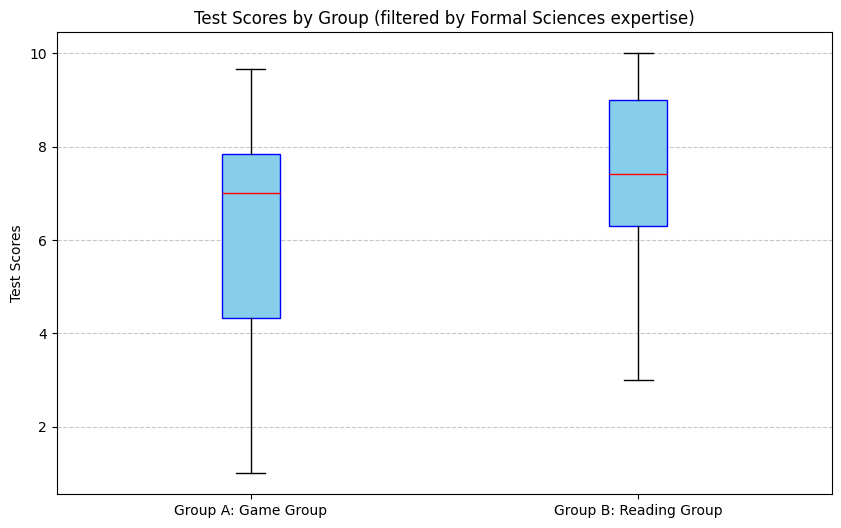

In [38]:
import matplotlib.pyplot as plt

# Step 1: Separate scores based on 'main_expertise' and 'in_game_group'
in_game_scores = []
not_in_game_scores = []

# Loop through each participant in the 'result' dictionary
for participant_id, pid in result.items():
    # Check if the participant has 'Formal sciences' expertise
    if pid["main_expertise"] == "Formal sciences":
        # Get the test score
        score = grade(pid["test"]["score"])

        # Ensure the score is a number (float or int)
        if isinstance(score, (int, float)):
            # Append the score to the appropriate group based on 'in_game_group'
            if pid["in_game_group"]:
                in_game_scores.append(score)
            else:
                not_in_game_scores.append(score)

# Step 2: Create the box plot for both groups
plt.figure(figsize=(10, 6))
plt.boxplot(
    [in_game_scores, not_in_game_scores],  # Data for the two groups
    tick_labels=["Group A: Game Group", "Group B: Reading Group"],  # Labels for the groups
    patch_artist=True,  # Fill the boxes with color
    boxprops=dict(facecolor="skyblue", color="blue"),  # Box color
    medianprops=dict(color="red")  # Median line color
)

# Step 3: Add titles and labels
plt.title("Test Scores by Group (filtered by Formal Sciences expertise)")
plt.ylabel("Test Scores")
# plt.xlabel("Group")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Step 4: Display the plot
plt.show()


In [39]:
from scipy import stats
# Shapiro-Wilk test for normality (alternative: use D'Agostino and Pearson's test)
stat_in_game, p_in_game = stats.shapiro(in_game_scores)
stat_not_in_game, p_not_in_game = stats.shapiro(not_in_game_scores)

print(f"In Game Group Normality Test p-value: {p_in_game}")
print(f"Not In Game Group Normality Test p-value: {p_not_in_game}")

# If both p-values are greater than 0.05, we assume normality and use t-test
if p_in_game > 0.05 and p_not_in_game > 0.05:
    print("Data is normally distributed. Using t-test.")
    # Perform a t-test
    t_stat, p_value = stats.ttest_ind(in_game_scores, not_in_game_scores)
    print(f"T={t_stat}, p={p_value}")

    # Calculate sample sizes
    n_in_game = len(in_game_scores)
    print(f"N_game={n_in_game}")
    n_not_in_game = len(not_in_game_scores)
    print(f"N_reading={n_not_in_game}")

    # Calculate Cohen's d (effect size)
    mean_diff = np.mean(in_game_scores) - np.mean(not_in_game_scores)
    pooled_sd = np.sqrt(((n_in_game - 1) * np.var(in_game_scores, ddof=1) +
                         (n_not_in_game - 1) * np.var(not_in_game_scores, ddof=1)) /
                        (n_in_game + n_not_in_game - 2))
    cohen_d = mean_diff / pooled_sd
    print(f"Cohen's d: {cohen_d}")

    # Calculate power using TTestIndPower
    analysis = TTestIndPower()
    power = analysis.power(effect_size=cohen_d, nobs1=n_in_game, alpha=0.05, ratio=n_not_in_game/n_in_game)
    print(f"T-Test Power: {power}")
else:
    print("Data is not normally distributed. Using Mann-Whitney U test.")
    # Perform a Mann-Whitney U test
    u_stat, p_value = stats.mannwhitneyu(in_game_scores, not_in_game_scores)
    print(f"U={u_stat}, p={p_value}")

if p_value < 0.05:
    print("Conclusion: There is a statistically significant difference between the two groups.")
else:
    print("Conclusion: There is no statistically significant difference between the two groups.")

In Game Group Normality Test p-value: 0.8030236005442044
Not In Game Group Normality Test p-value: 0.22506760280935284
Data is normally distributed. Using t-test.
T=-1.8925766843136935, p=0.06918166665238601
N_game=13
N_reading=16
Cohen's d: -0.7066767726010116
T-Test Power: 0.44646669959799523
Conclusion: There is no statistically significant difference between the two groups.


## User Engagement Scale

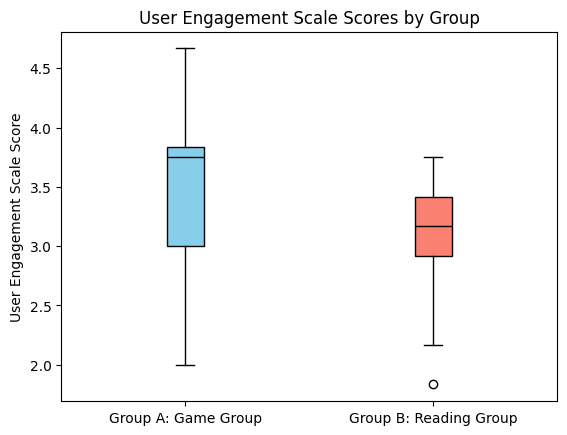

In [40]:
import matplotlib.pyplot as plt

# Step 1: Calculate mean UES for each participant and group them
in_game_group_means = []
not_in_game_group_means = []

for participant_id, data in result.items():
    ues = data.get("ues", {})

    # Reverse the values for pus1, pus2, and pus3
    reversed_ues = {key: (5 - value if key in ["pus1", "pus2", "pus3"] else value)
                    for key, value in ues.items() if isinstance(value, (int, float))}

    # Calculate the mean of all UES values
    ues_values = list(reversed_ues.values())
    if ues_values:
        mean_ues = sum(ues_values) / len(ues_values)
        if data["in_game_group"]:
            in_game_group_means.append(mean_ues)
        else:
            not_in_game_group_means.append(mean_ues)

# Step 2: Prepare data for the boxplot
data = [in_game_group_means, not_in_game_group_means]
labels = ["Group A: Game Group", "Group B: Reading Group"]

# Step 3: Create the boxplot
box = plt.boxplot(data, tick_labels=labels, patch_artist=True)

# Customize the first box (index 0)
box['boxes'][0].set(facecolor='skyblue', edgecolor='black')

# Customize the second box (index 1)
box['boxes'][1].set(facecolor='salmon', edgecolor='black')

# Customize the median line colors
box['medians'][0].set(color='black')
box['medians'][1].set(color='black')

# Step 4: Add titles and labels
plt.title("User Engagement Scale Scores by Group")
plt.ylabel("User Engagement Scale Score")
# plt.xlabel("Group")

# Step 5: Display the plot
plt.savefig("graphs/user_engagement_scale_by_group.svg", format="svg")
plt.show()

In [41]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

# Step 0: Detect Outliers
in_game_outliers = detect_outliers(in_game_group_means)
not_in_game_outliers = detect_outliers(not_in_game_group_means)

print("Outliers:")
print(f"In Game Group: {in_game_outliers}")
print(f"Not In Game Group: {not_in_game_outliers}")

# Step 1: Check for normality
shapiro_in_game = shapiro(in_game_group_means)
shapiro_not_in_game = shapiro(not_in_game_group_means)

print("\nShapiro-Wilk Test Results:")
print(f"In Game Group: W={shapiro_in_game.statistic}, p={shapiro_in_game.pvalue}")
print(f"Not In Game Group: W={shapiro_not_in_game.statistic}, p={shapiro_not_in_game.pvalue}")

# Step 2: Perform the appropriate test
if shapiro_in_game.pvalue > 0.05 and shapiro_not_in_game.pvalue > 0.05:
    # Both groups are normally distributed, use t-test
    t_stat, t_pvalue = ttest_ind(in_game_group_means, not_in_game_group_means, equal_var=False)
    print("\nT-Test Results:")
    print(f"T-Statistic: {t_stat}, p-value: {t_pvalue}")
    if t_pvalue < 0.05:
        print("There is a statistically significant difference between the groups.")
    else:
        print("There is no statistically significant difference.")
else:
    # Use Mann-Whitney U test
    u_stat, u_pvalue = mannwhitneyu(in_game_group_means, not_in_game_group_means, alternative='two-sided')
    print("\nMann-Whitney U Test Results:")
    print(f"U-Statistic: {u_stat}, p-value: {u_pvalue}")
    if u_pvalue < 0.05:
        print("There is a statistically significant difference between the groups.")
    else:
        print("There is no statistically significant difference.")

# Power calculation FOR T-TEST ONLY
mean_diff = np.mean(in_game_group_means) - np.mean(not_in_game_group_means)
pooled_sd = np.sqrt(((len(in_game_group_means) - 1) * np.var(in_game_group_means, ddof=1) +
                     (len(not_in_game_group_means) - 1) * np.var(not_in_game_group_means, ddof=1)) /
                    (len(in_game_group_means) + len(not_in_game_group_means) - 2))
cohen_d = mean_diff / pooled_sd
print(f"Cohen's d: {cohen_d}")

alpha = 0.05  # Significance level
n1 = len(in_game_group_means)  # Sample size of group 1
n2 = len(not_in_game_group_means)  # Sample size of group 2

# Calculate power
analysis = TTestIndPower()
power = analysis.power(effect_size=cohen_d, nobs1=n1, alpha=alpha, ratio=n2/n1)
print(f"T-Test Power: {power}")

Outliers:
In Game Group: []
Not In Game Group: [1.8333333333333333]

Shapiro-Wilk Test Results:
In Game Group: W=0.9321069827761328, p=0.07785141538577088
Not In Game Group: W=0.9343161476023797, p=0.08823225777950827

T-Test Results:
T-Statistic: 2.549318270217264, p-value: 0.014165571069198855
There is a statistically significant difference between the groups.
Cohen's d: 0.6938365504429935
T-Test Power: 0.7061073714253766


In [42]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

# Step 0: Detect Outliers
def detect_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return [x for x in data if x < lower_bound or x > upper_bound]

def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return [x for x in data if lower_bound <= x <= upper_bound]

# Detect outliers
in_game_outliers = detect_outliers(in_game_group_means)
not_in_game_outliers = detect_outliers(not_in_game_group_means)

print("Outliers:")
print(f"In Game Group: {in_game_outliers}")
print(f"Not In Game Group: {not_in_game_outliers}")

# Remove outliers
in_game_group_means_cleaned = remove_outliers(in_game_group_means)
not_in_game_group_means_cleaned = remove_outliers(not_in_game_group_means)

print("\nCleaned Data:")
print(f"In Game Group: {in_game_group_means_cleaned}")
print(f"Not In Game Group: {not_in_game_group_means_cleaned}\n")

# Step 1: Check for normality
shapiro_in_game = shapiro(in_game_group_means_cleaned)
shapiro_not_in_game = shapiro(not_in_game_group_means_cleaned)

print("Shapiro-Wilk Test Results:")
print(f"In Game Group: W={shapiro_in_game.statistic}, p={shapiro_in_game.pvalue}")
print(f"Not In Game Group: W={shapiro_not_in_game.statistic}, p={shapiro_not_in_game.pvalue}")

# Step 2: Perform the appropriate test
if shapiro_in_game.pvalue > 0.05 and shapiro_not_in_game.pvalue > 0.05:
    # Both groups are normally distributed, use t-test
    t_stat, t_pvalue = ttest_ind(in_game_group_means_cleaned, not_in_game_group_means_cleaned, equal_var=False)
    print("\nT-Test Results:")
    print(f"T-Statistic: {t_stat}, p-value: {t_pvalue}")
    if t_pvalue < 0.05:
        print("There is a statistically significant difference between the groups.")
    else:
        print("There is no statistically significant difference.")
else:
    # Use Mann-Whitney U test
    u_stat, u_pvalue = mannwhitneyu(in_game_group_means_cleaned, not_in_game_group_means_cleaned, alternative='two-sided')
    print("\nMann-Whitney U Test Results:")
    print(f"U-Statistic: {u_stat}, p-value: {u_pvalue}")
    if u_pvalue < 0.05:
        print("There is a statistically significant difference between the groups.")
    else:
        print("There is no statistically significant difference.")


Outliers:
In Game Group: []
Not In Game Group: [1.8333333333333333]

Cleaned Data:
In Game Group: [4.666666666666667, 3.5833333333333335, 3.0, 3.4166666666666665, 3.8333333333333335, 2.9166666666666665, 3.4166666666666665, 2.9166666666666665, 2.1666666666666665, 3.6666666666666665, 3.8333333333333335, 3.75, 4.333333333333333, 2.3333333333333335, 4.333333333333333, 3.0, 3.75, 3.8333333333333335, 2.0, 4.333333333333333, 2.9166666666666665, 3.8333333333333335, 3.75, 4.083333333333333, 3.75, 3.5833333333333335, 3.8333333333333335]
Not In Game Group: [2.75, 3.3333333333333335, 2.9166666666666665, 2.6666666666666665, 3.0833333333333335, 3.75, 3.0, 3.1666666666666665, 2.5833333333333335, 2.9166666666666665, 2.9166666666666665, 2.6666666666666665, 3.5, 3.5833333333333335, 3.6666666666666665, 3.5, 3.3333333333333335, 3.4166666666666665, 3.25, 3.4166666666666665, 3.3333333333333335, 2.1666666666666665, 3.75, 3.0, 3.4166666666666665, 3.1666666666666665]

Shapiro-Wilk Test Results:
In Game Group: 

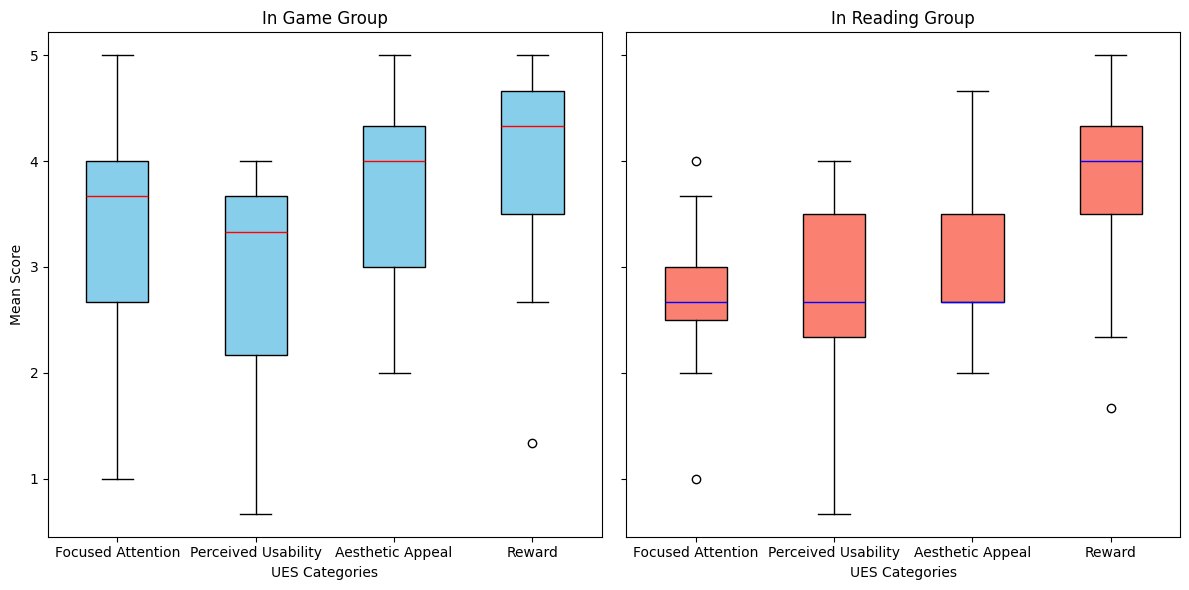

In [43]:
import matplotlib.pyplot as plt

# Step 1: Initialize lists for each group
in_game_data = {"fas": [], "pus": [], "aes": [], "rws": []}
not_in_game_data = {"fas": [], "pus": [], "aes": [], "rws": []}

# Step 2: Iterate through participants and calculate averages
for participant_id, data in result.items():
    ues = data.get("ues", {})
    fas = [ues.get("fas1", 0), ues.get("fas2", 0), ues.get("fas3", 0)]
    pus = [5 - ues.get("pus1", 0), 5 - ues.get("pus2", 0), 5 - ues.get("pus3", 0)]  # Reverse pus1, pus2 and pus3
    aes = [ues.get("aes1", 0), ues.get("aes2", 0), ues.get("aes3", 0)]
    rws = [ues.get("rws1", 0), ues.get("rws2", 0), ues.get("rws3", 0)]

    # Calculate means for each group
    fas_mean = sum(fas) / len(fas) if fas else 0
    pus_mean = sum(pus) / len(pus) if pus else 0
    aes_mean = sum(aes) / len(aes) if aes else 0
    rws_mean = sum(rws) / len(rws) if rws else 0

    # Append to the appropriate group
    if data["in_game_group"]:
        in_game_data["fas"].append(fas_mean)
        in_game_data["pus"].append(pus_mean)
        in_game_data["aes"].append(aes_mean)
        in_game_data["rws"].append(rws_mean)
    else:
        not_in_game_data["fas"].append(fas_mean)
        not_in_game_data["pus"].append(pus_mean)
        not_in_game_data["aes"].append(aes_mean)
        not_in_game_data["rws"].append(rws_mean)

# Step 3: Prepare data for box plots
in_game_values = [in_game_data["fas"], in_game_data["pus"], in_game_data["aes"], in_game_data["rws"]]
not_in_game_values = [not_in_game_data["fas"], not_in_game_data["pus"], not_in_game_data["aes"],
                      not_in_game_data["rws"]]
labels = ["Focused Attention", "Perceived Usability", "Aesthetic Appeal", "Reward"]

# Step 4: Create the box plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Left graph: In Game Group
axes[0].boxplot(in_game_values, tick_labels=labels, patch_artist=True,
                boxprops=dict(facecolor='skyblue', color='black'),
                medianprops=dict(color='red'))
axes[0].set_title("In Game Group")
axes[0].set_ylabel("Mean Score")
axes[0].set_xlabel("UES Categories")

# Right graph: Not In Game Group
axes[1].boxplot(not_in_game_values, tick_labels=labels, patch_artist=True,
                boxprops=dict(facecolor='salmon', color='black'),
                medianprops=dict(color='blue'))
axes[1].set_title("In Reading Group")
axes[1].set_xlabel("UES Categories")

# Step 5: Display the plots
plt.tight_layout()
plt.show()
